# Objective
------------
Create the different part of the workflow that involves coding

- Author: Victor Rosales
- Date: 10/12/2024

# Libraries

In [1]:
from uszipcode import SearchEngine

# from geopy.geocoders import Nominatim
# from geopy.extra.rate_limiter import RateLimiter

import pandas as pd
import numpy as np

from retry_requests import retry
import openmeteo_requests
import requests_cache
import requests

from zipfile import ZipFile
import json
import uuid
import time
import os



# Functions

## Weather

In [2]:
def get_weather_dataframe(latitude, longitude, start_date, end_date):
    variable_list = [
        "temperature_2m", 
        "relative_humidity_2m", 
        "dew_point_2m", 
        "apparent_temperature", 
        "precipitation", 
        "rain", 
        "snowfall", 
        "snow_depth", 
        "weather_code", 
        "pressure_msl", 
        "surface_pressure", 
        "cloud_cover", 
        "cloud_cover_low", 
        "cloud_cover_mid", 
        "cloud_cover_high", 
        "et0_fao_evapotranspiration", 
        "vapour_pressure_deficit", 
        "wind_speed_10m", 
        "soil_temperature_0_to_7cm", 
        "soil_moisture_0_to_7cm", 
        "soil_temperature_7_to_28cm", 
        "soil_moisture_7_to_28cm", 
        "wind_speed_100m"
    ]

    responses = request_open_meteo(latitude, longitude, start_date, end_date, variable_list)
    
    # Process location
    response = responses[0]
    print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
    print(f"Elevation: {response.Elevation()} m asl")
    print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")
    
    # Process hourly data. The order of variables needs to be the same as requested.
    hourly = response.Hourly()
    
    # Create DataFrame
    hourly_data = {
        "date": pd.date_range(
        	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
        	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
        	freq = pd.Timedelta(seconds = hourly.Interval()),
        	inclusive = "left"
        )
    }

    hourly = response.Hourly()
    hourly_data["temperature_2m"] = hourly.Variables(0).ValuesAsNumpy()
    hourly_data["relative_humidity_2m"] = hourly.Variables(1).ValuesAsNumpy()
    hourly_data["dew_point_2m"] = hourly.Variables(2).ValuesAsNumpy()
    hourly_data["apparent_temperature"] = hourly.Variables(3).ValuesAsNumpy()
    hourly_data["precipitation"] = hourly.Variables(4).ValuesAsNumpy()
    hourly_data["rain"] = hourly.Variables(5).ValuesAsNumpy()
    hourly_data["snowfall"] = hourly.Variables(6).ValuesAsNumpy()
    hourly_data["snow_depth"] = hourly.Variables(7).ValuesAsNumpy()
    hourly_data["weather_code"] = hourly.Variables(8).ValuesAsNumpy()
    hourly_data["pressure_msl"] = hourly.Variables(9).ValuesAsNumpy()
    hourly_data["surface_pressure"] = hourly.Variables(10).ValuesAsNumpy()
    hourly_data["cloud_cover"] = hourly.Variables(11).ValuesAsNumpy()
    hourly_data["cloud_cover_low"] = hourly.Variables(12).ValuesAsNumpy()
    hourly_data["cloud_cover_mid"] = hourly.Variables(13).ValuesAsNumpy()
    hourly_data["cloud_cover_high"] = hourly.Variables(14).ValuesAsNumpy()
    hourly_data["et0_fao_evapotranspiration"] = hourly.Variables(15).ValuesAsNumpy()
    hourly_data["vapour_pressure_deficit"] = hourly.Variables(16).ValuesAsNumpy()
    hourly_data["wind_speed_10m"] = hourly.Variables(17).ValuesAsNumpy()
    hourly_data["soil_temperature_0_to_7cm"] = hourly.Variables(18).ValuesAsNumpy()
    hourly_data["soil_moisture_0_to_7cm"] = hourly.Variables(19).ValuesAsNumpy()
    hourly_data["soil_temperature_7_to_28cm"] = hourly.Variables(20).ValuesAsNumpy()
    hourly_data["soil_moisture_7_to_28cm"] = hourly.Variables(21).ValuesAsNumpy()
    hourly_data["wind_speed_100m"] = hourly.Variables(22).ValuesAsNumpy()
    
    df_weather = pd.DataFrame(data = hourly_data)

    return df_weather

In [3]:
def request_open_meteo(latitude, longitude, start_date, end_date, variable_list):
    # Setup the Open-Meteo API client with cache and retry on error
    cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
    retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
    openmeteo = openmeteo_requests.Client(session = retry_session)
    
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
    	"latitude": latitude,
    	"longitude": longitude,
    	"start_date": start_date,
    	"end_date": end_date,
    	"hourly": variable_list,
        "timezone": "auto"
    }
    responses = openmeteo.weather_api(url, params=params)

    return responses

## Metro Bike

In [4]:
def generate_metro_stations_dataframe(df_metro):
    start_station_columns = [
        'start_station_id',
        'start_lat', 
        'start_lon', 
        'start_station_name'
    ]
    end_station_columns = [
        'end_station_id', 
        'end_lat', 
        'end_lon',
        'end_station_name'
    ]

    station_columns = start_station_columns + end_station_columns
    df_stations = df_metro[station_columns].drop_duplicates()

    # get stations from start and end
    df_stations_start = df_stations[start_station_columns]
    df_stations_start.columns = df_stations_start.columns.str.replace("start_", "")
    df_stations_start = get_metro_unique_stations(df_stations_start)

    df_stations_end = df_stations[end_station_columns]
    df_stations_end.columns = df_stations_end.columns.str.replace("end_", "")
    df_stations_end = get_metro_unique_stations(df_stations_end)
    
    # df_stations_start = generate_start_stations(df_stations, start_station_columns)
    # df_stations_end = generate_end_stations(df_stations, end_station_columns)

    # combine both stations (start, end)
    df_stations = pd.concat([df_stations_start, df_stations_end])
    df_stations = df_stations.drop_duplicates()
    df_stations = df_stations.dropna(subset=["lat", "lon"])
    df_stations = df_stations.groupby(by=["station_id"]).agg(
        lat=('lat', safe_mode),
        lon=('lon', safe_mode),
        station_name=('station_name', 'first')
    )
    df_stations = df_stations.reset_index()

    # add zip codes
    df_stations = rectify_coordinates(df_stations, city_latitude=34.059753, city_longitude=-118.2375)
    zip_dict = get_zip_code_by_coordenates(df_stations)
    df_stations["zip_code"] = zip_dict

    # add city
    df_stations["city"] = "Los Angeles"

    # add unique identifier
    uuids = [str(uuid.uuid4()) for _ in range(len(df_stations))]
    df_stations.insert(0, 'station_uuid', uuids)

    # rename columns for homogeneity
    df_stations = df_stations.rename(
        columns={
            "station_id": "original_station_id",
            "lat": "latitude",
            "lon": "longitude"
        }
    )

    return df_stations

def get_metro_unique_stations(df_stations_terminal):
    df_stations_terminal = df_stations_terminal.drop_duplicates()
    df_stations_terminal = df_stations_terminal.sort_values(by=["station_id"])
    df_stations_terminal = df_stations_terminal.groupby(by=["station_id"]).agg(
        lat=('lat', safe_mode),
        lon=('lon', safe_mode),
        station_name=('station_name', 'first')
    )
    df_stations_terminal = df_stations_terminal.reset_index()

    return df_stations_terminal


# def generate_start_stations(df_stations, start_station_columns):
#     df_stations_start = df_stations[start_station_columns]
#     df_stations_start = df_stations_start.drop_duplicates()
#     df_stations_start = df_stations_start.sort_values(by=["start_station_id"])
#     df_stations_start = df_stations_start.groupby(by=["start_station_id"]).first()
#     df_stations_start = df_stations_start.reset_index()
#     df_stations_start.columns = df_stations_start.columns.str.replace("start_", "")#.str.replace("start ", "")
    
#     return df_stations_start


# def generate_end_stations(df_stations, end_station_columns):
#     df_stations_end = df_stations[end_station_columns]
#     df_stations_end = df_stations_end.drop_duplicates()
#     df_stations_end = df_stations_end.sort_values(by=["end_station_id"])
#     df_stations_end = df_stations_end.groupby(by=["end_station_id"]).first()
#     df_stations_end = df_stations_end.reset_index()
#     df_stations_end.columns = df_stations_end.columns.str.replace("end_", "")#.str.replace("end ", "")
    
#     return df_stations_end

In [5]:
def generate_metro_bikes_dataframe(df_metro):
    df_bikes = df_metro[["bike_id", "bike_type"]].drop_duplicates()
    df_bikes["bike_id"] = df_bikes["bike_id"].astype(str)
    
    df_bikes = df_bikes.groupby(by=["bike_id"]).agg(safe_mode)
    df_bikes = df_bikes.reset_index()
    
    # remove the IDs that looks as testing IDs
    valid_ids_mask = df_bikes['bike_id'].str.count(r'\d') >= 4
    df_bikes = df_bikes.loc[valid_ids_mask]
    
    # add unique identifier
    uuids = [str(uuid.uuid4()) for _ in range(len(df_bikes))]
    df_bikes.insert(0, 'bike_uuid', uuids)
    
    # rename columns for homogeneity
    df_bikes = df_bikes.rename(
        columns={
            "bike_id": "original_bike_id"
        }
    )
    
    return df_bikes

## Capital bike

In [24]:
def generate_capital_stations_dataframe(df_capital):
    start_station_columns = [
        'start_station_id',
        'start_lat', 
        'start_lon', 
        'start_station_name'
    ]
    end_station_columns = [
        'end_station_id', 
        'end_lat', 
        'end_lon',
        'end_station_name'
    ]
    
    station_columns = start_station_columns + end_station_columns
    df_stations = df_capital[station_columns].drop_duplicates()
    
    # get stations from start and end
    df_stations_start = df_stations[start_station_columns].copy()
    df_stations_start.columns = df_stations_start.columns.str.replace("start_", "")
    df_stations_start = get_capital_unique_stations(df_stations_start)
    
    df_stations_end = df_stations[end_station_columns].copy()
    df_stations_end.columns = df_stations_end.columns.str.replace("end_", "")
    df_stations_end = get_capital_unique_stations(df_stations_end)
    
    # combine both stations (start, end)
    df_stations = pd.concat([df_stations_start, df_stations_end])
    df_stations = df_stations.drop_duplicates()
    df_stations = df_stations.dropna(subset=["lat", "lon"])
    df_stations = df_stations.groupby(by=["station_id"]).agg(
        lat=('lat', safe_mode),
        lon=('lon', safe_mode),
        station_name=('station_name', 'first')
    )
    df_stations = df_stations.reset_index()
    
    # add zip codes
    df_stations = rectify_coordinates(df_stations, city_latitude=38.910366, city_longitude=-77.07251)
    zip_dict = get_zip_code_by_coordenates(df_stations)
    df_stations["zip_code"] = zip_dict
    
    # add city
    df_stations["city"] = "Washington D.C."

    # add unique identifier
    uuids = [str(uuid.uuid4()) for _ in range(len(df_stations))]
    df_stations.insert(0, 'station_uuid', uuids)

    # rename columns for homogeneity
    df_stations = df_stations.rename(
        columns={
            "station_id": "original_station_id",
            "lat": "latitude",
            "lon": "longitude"
        }
    )

    return df_stations

In [9]:
def get_capital_unique_stations(df_stations_terminal):
    df_stations_terminal.loc[:, "lat"] = df_stations_terminal.loc[:, "lat"].astype(str)
    df_stations_terminal.loc[:, "lon"] = df_stations_terminal.loc[:, "lon"].astype(str)
    
    valid_lat_mask = df_stations_terminal['lat'].str.count(r'\d') > 6
    valid_lon_mask = df_stations_terminal['lon'].str.count(r'\d') > 6
    df_stations_terminal = df_stations_terminal.loc[valid_lat_mask & valid_lon_mask]
    
    df_stations_terminal.loc[:, "lat"] = df_stations_terminal.loc[:, "lat"].astype(float)
    df_stations_terminal.loc[:, "lon"] = df_stations_terminal.loc[:, "lon"].astype(float)
    
    df_stations_terminal = df_stations_terminal.groupby(by=["lat", "lon"]).first()
    df_stations_terminal = df_stations_terminal.reset_index()
    
    df_stations_terminal.loc[:, "station_id"] = df_stations_terminal["station_id"].astype(int)
    
    df_stations_terminal = df_stations_terminal.groupby(by=["station_id"]).agg(
        lat=('lat', safe_mode),
        lon=('lon', safe_mode),
        station_name=('station_name', 'first')
    )
    df_stations_terminal = df_stations_terminal.reset_index()

    return df_stations_terminal

In [10]:
def generate_capital_bikes_dataframe(df_capital):
    df_bikes = df_capital[["bike_id", "bike_type"]].drop_duplicates()
    df_bikes["bike_id"] = df_bikes["bike_id"].astype(str)
    
    df_bikes = df_bikes.groupby(by=["bike_id"]).agg(safe_mode)
    df_bikes = df_bikes.reset_index()
    
    # remove the IDs that looks as testing IDs
    valid_ids_mask = df_bikes['bike_id'].str.count(r'\d') >= 4
    df_bikes = df_bikes[valid_ids_mask]
    
    # base on before 2020 there were not ebikes and there was bike IDs in the datasets
    df_bikes.loc[df_bikes["bike_type"].isna(), "bike_type"] = "classic_bike" 
    
    # add unique identifier
    uuids = [str(uuid.uuid4()) for _ in range(len(df_bikes))]
    df_bikes.insert(0, 'bike_uuid', uuids)
    
    # rename columns for homogeneity
    df_bikes = df_bikes.rename(
        columns={
            "bike_id": "original_bike_id"
        }
    )

    return df_bikes

## Demographics

In [11]:
def generate_demogrpics_dataframe(df_stations):
    variables_dict = {
        "B01001_001E": "population",
        "B01001_002E": "population_male",
        "B01001_026E": "population_female",
        "B01001A_001E": "population_white",
        "B01001B_001E": "population_black",
        "B01001C_001E": "population_american_indian_and_alaska_native",
        "B01001D_001E": "population_asian",
        "B01001E_001E": "population_native_hawaiian_and_other_pacific_islander",
        "B01001F_001E": "population_other_race",
        "B01001G_001E": "population_two_or_more_races",
        "B01001I_001E": "population_hipanic_or_latino",
        "B01002_001E": "median_age",
        "B01002_002E": "median_age_male",
        "B01002_003E": "median_age_female",
        "B06008_002E": "never_married",
        "B06008_003E": "married",
        "B06008_004E": "divorced",
        "B06008_005E": "separated",
        "B06008_006E": "widowed",
        "B06010_002E": "individual_no_income",
        "B06010_003E": "individual_with_income",
        "B08006_002E": "transportation_work_car_truck_van",
        "B08006_008E": "transportation_work_public_transportation",
        "B08006_014E": "transportation_work_bicycle",
        "B08006_015E": "transportation_work_walked",
        "B08006_016E": "transportation_work_taxicab_motorcycle_or_other_means",
        "B08006_017E": "transportation_work_home_office",
        "B19001_002E": "household_income_1_to_9999",
        "B19001_003E": "household_income_10000_to_14999",
        "B19001_004E": "household_income_15000_to_19999",
        "B19001_005E": "household_income_20000_to_24999",
        "B19001_006E": "household_income_25000_to_29999",
        "B19001_007E": "household_income_30000_to_34999",
        "B19001_008E": "household_income_35000_to_39999",
        "B19001_009E": "household_income_40000_to_44999",
        "B19001_010E": "household_income_45000_to_49999",
        "B19001_011E": "household_income_50000_to_59999",
        "B19001_012E": "household_income_60000_to_74999",
        "B19001_013E": "household_income_75000_to_99999",
        "B19001_014E": "household_income_100000_to_124999",
        "B19001_015E": "household_income_125000_to_149999",
        "B19001_016E": "household_income_150000_to_199999",
        "B19001_017E": "household_income_200000_to_more",
        "B19013_001E": "median_household_income",
    }

    variables = ",".join(variables_dict.keys()) 
    year = 2023 # year of the census data
    api_key = os.environ['US_CENSUS_API_KEY'] # need to stablish a valid API key

    zip_codes = df_stations["zip_code"].drop_duplicates().to_list()
    failed_zip_codes = []
    
    df_demographics = pd.DataFrame()
    
    for zip_code in zip_codes:
        print(zip_code)
        data = request_census_data(zip_code, variables, year, api_key)
    
        # No information in that zip code
        if data is None:
            failed_zip_codes.append(zip_code) # handle in following process
            continue
            
        header = data[0][::-1]
        result = data[1][::-1]
        
        df_demographics_row = pd.DataFrame([result], columns=header)
        df_demographics = pd.concat([df_demographics, df_demographics_row])
    
    # change name for interpretability
    df_demographics = df_demographics.rename(columns=variables_dict)
    df_demographics = df_demographics.rename(columns={'zip code tabulation area': 'zip_code'})
    
    # Change to numeric values
    for variable in list(variables_dict.values()) + ["zip_code"]:
        df_demographics[variable] = pd.to_numeric(df_demographics[variable])
    
    # insert mean values for zip codes with no information
    for zip_code in failed_zip_codes:
        df_demographics_row = df_demographics.median().to_frame().T
        df_demographics_row["zip_code"] = zip_code
        df_demographics = pd.concat([df_demographics, df_demographics_row])
    
    df_demographics = df_demographics.reset_index(drop=True)
    
    # add unique identifier
    uuids = [str(uuid.uuid4()) for _ in range(len(df_demographics))]
    df_demographics.insert(0, 'zip_code_uuid', uuids)

    return df_demographics

In [12]:
def request_census_data(zip_code, variables, year, api_key):
    # Construct the API request URL
    url = f"https://api.census.gov/data/{year}/acs/acs5?get={variables}&for=zip%20code%20tabulation%20area:{zip_code}&key={api_key}"
    
    # Make the request to the API
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for bad status codes
        data = response.json()

        return data

    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")
    except json.JSONDecodeError:
        print("Error decoding JSON. Check your API key and URL.")

        return None

## Location

In [13]:
def get_zip_code_by_coordenates(df_stations, max_retries=30):
    zip_dict = {}

    for _ in range(max_retries):
        zip_dict = populate_zip_code_dict_by_coordenates(df_stations, zip_dict)

    return zip_dict


def populate_zip_code_dict_by_coordenates(df_stations, zip_dict):
    try:
        for i, row in enumerate(df_stations.values):
            if i not in zip_dict:
                lat = row[1]
                lon = row[2]
                # print(i, lat, lon)
                zip_dict[i] = get_zip_code(lat, lon)
                time.sleep(0.01)
    except Exception as e:
        print(f"An error occurred in register {i}: - Error: {e}")

    return zip_dict
        

# def get_zip_code(latitude, longitude):
#     geolocator = Nominatim(user_agent="bike_share_geocoder")
#     geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
    
#     # Perform reverse geocoding
#     location = geolocator.reverse(f"{latitude},{longitude}")
    
#     # Extract the postal code from the raw address data
#     address = location.raw['address']
#     zipcode = address.get('postcode')

#     return zipcode

def get_zip_code(latitude, longitude):
    search = SearchEngine()
    result = search.by_coordinates(lat=latitude, lng=longitude, returns=1)
    
    if result:
        zip_code = result[0].zipcode
        print(f"The ZIP code for coordinates ({latitude}, {longitude}) is: {zip_code}")
    else:
        print(f"No ZIP code found for coordinates ({latitude}, {longitude}).")
        zip_code = np.nan

    return zip_code

## Feature Engineering

In [42]:
def haversine_vectorized(df_stations, lat_city, lon_city):
    # Approximate Earth radius in kilometers
    R = 6371

    # Convert latitude and longitude from degrees to radians
    lat_station_rad = np.radians(df_stations["lat"])
    lon_station_rad = np.radians(df_stations["lon"])
    lat_city_rad = np.radians(lat_city)
    lon_city_rad = np.radians(lon_city)

    # Calculate differences
    dlat = lat_city_rad - lat_station_rad
    dlon = lon_city_rad - lon_station_rad

    # Haversine formula
    a = np.sin(dlat / 2.0)**2 + np.cos(lat_station_rad) * np.cos(lat_city_rad) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance_km = R * c
    
    return distance_km

## Utils

In [14]:
def unzip_files(zip_file_path, destination_path=None):
    destination_path = destination_path or os.path.dirname(zip_file_path)
    
    with ZipFile(zip_file_path, 'r') as zip_object:
        zip_object.extractall(path=destination_path)
        
    print(f"All files extracted from '{zip_file_path}' to '{destination_path}'.")

In [15]:
def safe_mode(series):
    # Calculate the mode, which returns a Series
    mode_result = series.mode()
    # Check if the result is empty (meaning all values were NaN)
    if mode_result.empty:
        return np.nan
    # Otherwise, return the first mode value
    return mode_result.iloc[0]

In [16]:
def rectify_coordinates(df_stations, city_latitude, city_longitude, tolerance=3):
    inside_tolerance = (df_stations["lat"].abs() - abs(city_latitude)).abs() <= tolerance
    different_sign = np.sign(df_stations["lat"]) != np.sign(city_latitude)
    
    condition = inside_tolerance & different_sign
    df_stations.loc[condition, "lat"] = df_stations.loc[condition, "lat"] * -1

    inside_tolerance = (df_stations["lon"].abs() - abs(city_longitude)).abs() <= tolerance
    different_sign = np.sign(df_stations["lon"]) != np.sign(city_longitude)
    
    condition = inside_tolerance & different_sign
    df_stations.loc[condition, "lon"] = df_stations.loc[condition, "lon"] * -1

    return df_stations

In [259]:
def transform_nexted_dict_for_dataframe(data):
    """
    Transforms a nested dictionary containing lists of dictionaries into a flattened
    dictionary where each sub-item becomes a new column.
    """
    flattened_data = {}
    
    for key, value in data.items():
        # Handle simple key-value pairs (like 'population' and 'median_home_value')
        if not isinstance(value, list):
            flattened_data[key] = [value]
        
        # Handle lists containing a single dictionary with a 'values' key
        elif isinstance(value, list) and len(value) == 1 and 'values' in value[0]:
            # Use a list comprehension to extract and rename the nested data
            for item in value[0]['values']:
                new_key = f"{key}_{item['x']}".lower()
                new_key = new_key.replace(" ", "_").replace("'", "").replace(",", "")
                new_key = new_key.replace("&", "and").replace("-", "_").replace("$", "")
                new_key = new_key.replace("<", "less").replace("+", "_and_more")
                new_key = new_key.replace("occupide", "occupied")
                flattened_data[new_key] = [item['y']]
    
    return flattened_data

# Workflow

## Data Acquisition

In [17]:
# Check data available
raw_data_folder = "./RawData"

os.listdir(raw_data_folder)

['CapitalBike', 'MetroBike', 'OpenMeteo']

### Metro Bike

Download data from: https://bikeshare.metro.net/about/data/

In [294]:
metro_folder = f"{raw_data_folder}/MetroBike"

zip_file_list = [file for file in os.listdir(metro_folder) if file.endswith(".zip")]

for zip_file in zip_file_list:
    zip_file_path = f"{metro_folder}/{zip_file}"
    unzip_files(zip_file_path)

All files extracted from './RawData/MetroBike/la_metro_gbfs_trips_Q1_2017-2.zip' to './RawData/MetroBike'.
All files extracted from './RawData/MetroBike/la_metro_gbfs_trips_Q2_2017.csv.zip' to './RawData/MetroBike'.
All files extracted from './RawData/MetroBike/metro-bike-share-trips-2016-q4.csv.zip' to './RawData/MetroBike'.
All files extracted from './RawData/MetroBike/metro-bike-share-trips-2017-q3.csv.zip' to './RawData/MetroBike'.
All files extracted from './RawData/MetroBike/metro-bike-share-trips-2017-q4-v2.csv.zip' to './RawData/MetroBike'.
All files extracted from './RawData/MetroBike/metro-bike-share-trips-2018-q1.csv.zip' to './RawData/MetroBike'.
All files extracted from './RawData/MetroBike/metro-bike-share-trips-2018-q2.csv.zip' to './RawData/MetroBike'.
All files extracted from './RawData/MetroBike/metro-bike-share-trips-2018-q3.csv.zip' to './RawData/MetroBike'.
All files extracted from './RawData/MetroBike/metro-bike-share-trips-2018-q4.csv.zip' to './RawData/MetroBike

### Capital bike

Download data from: https://s3.amazonaws.com/capitalbikeshare-data/index.html 

In [295]:
capital_folder = f"{raw_data_folder}/CapitalBike"

zip_file_list = [file for file in os.listdir(capital_folder) if file.endswith(".zip")]

for zip_file in zip_file_list:
    zip_file_path = f"{capital_folder}/{zip_file}"
    unzip_files(zip_file_path)

All files extracted from './RawData/CapitalBike/2016-capitalbikeshare-tripdata.zip' to './RawData/CapitalBike'.
All files extracted from './RawData/CapitalBike/2017-capitalbikeshare-tripdata.zip' to './RawData/CapitalBike'.
All files extracted from './RawData/CapitalBike/201801-capitalbikeshare-tripdata.zip' to './RawData/CapitalBike'.
All files extracted from './RawData/CapitalBike/201803-capitalbikeshare-tripdata.zip' to './RawData/CapitalBike'.
All files extracted from './RawData/CapitalBike/201804-capitalbikeshare-tripdata.zip' to './RawData/CapitalBike'.
All files extracted from './RawData/CapitalBike/201805-capitalbikeshare-tripdata.zip' to './RawData/CapitalBike'.
All files extracted from './RawData/CapitalBike/201806-capitalbikeshare-tripdata.zip' to './RawData/CapitalBike'.
All files extracted from './RawData/CapitalBike/201807-capitalbikeshare-tripdata.zip' to './RawData/CapitalBike'.
All files extracted from './RawData/CapitalBike/201808-capitalbikeshare-tripdata.zip' to './

### Open Meteo

In [29]:
open_meteo_folder = f"{raw_data_folder}/OpenMeteo"

In [31]:
start_date = "2016-01-01"
end_date = "2025-10-01"

city_information = {
    "LosAngeles": {
        "coordinates": (34.059753, -118.2375),
        "timezone": "America/Los_Angeles",
    },
    "WashingtonDC": {
        "coordinates": (38.910366, -77.07251),
        "timezone": "America/New_York",
    },
    # "WashingtonVirginia": {
    #     "coordinates": (38.69947, -78.10626),
    #     "timezone": "America/New_York",
    # }
}

for city, info in city_information.items():
    print(city)
    latitude, longitude = info["coordinates"]
    df_weather = get_weather_dataframe(latitude, longitude, start_date, end_date)
    
    df_weather["date"] = df_weather["date"].dt.tz_convert(info["timezone"])
    df_weather.set_index("date")
    df_weather.to_csv(f"{open_meteo_folder}/{city}.csv", index=False)
    print("\n" + "----"*15)
    time.sleep(70)

LosAngeles
Coordinates: 34.05975341796875°N -118.23750305175781°E
Elevation: 92.0 m asl
Timezone difference to GMT+0: -25200s

------------------------------------------------------------
WashingtonDC
Coordinates: 38.91036605834961°N -77.072509765625°E
Elevation: 56.0 m asl
Timezone difference to GMT+0: -14400s

------------------------------------------------------------


<Axes: xlabel='date'>

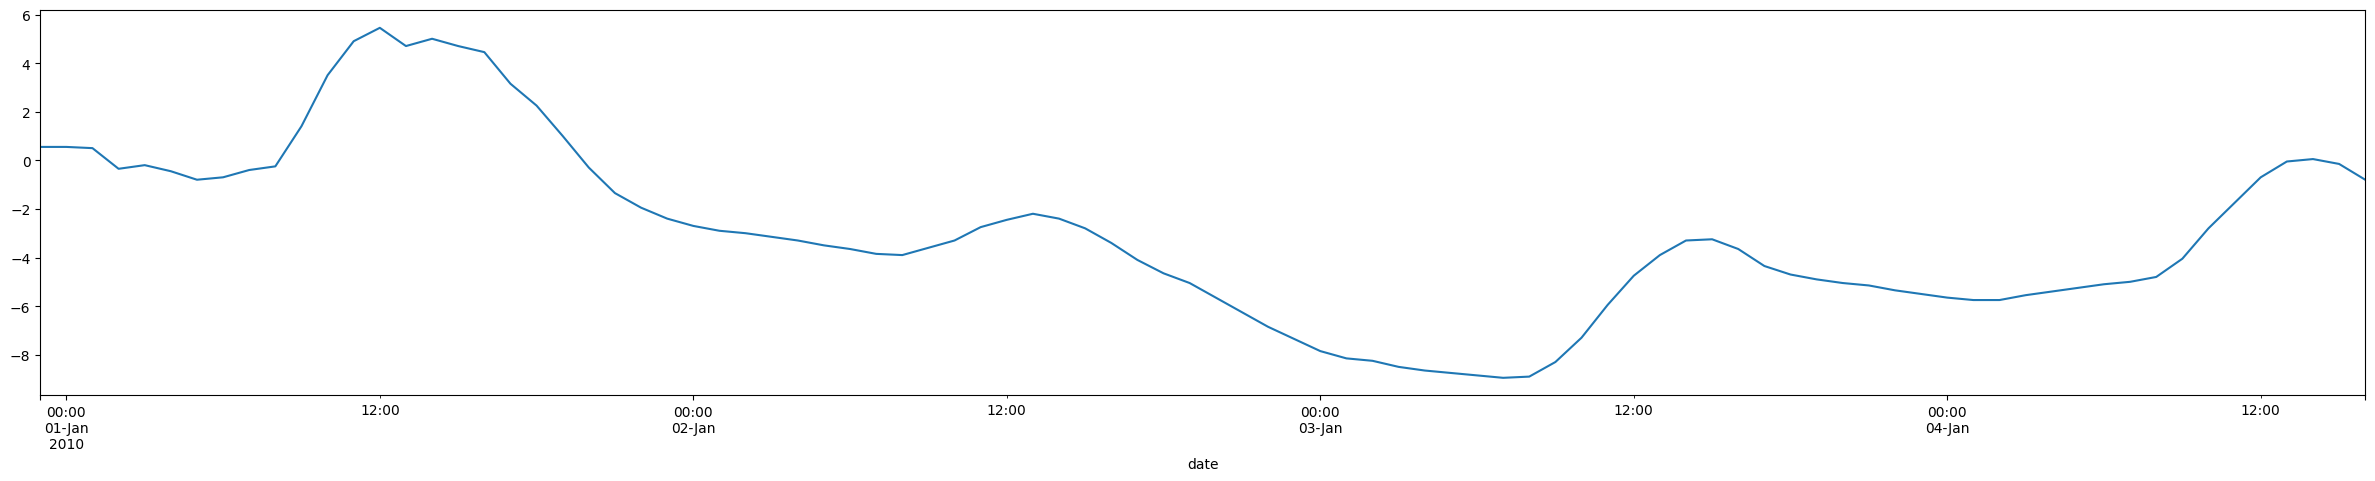

In [298]:
# Check the temperatures match the common sense
df_weather.set_index("date")["temperature_2m"].iloc[:90].plot(figsize=(30,5))

### US Census ACS

In [ ]:
# Due to the vast amount of data, this data will be acquired based on the zip codes of the bike stations

# Please check the senction below

## Data Homologation / Cleaning

### Metro Bike

In [299]:
metro_name_map = {
    "trip_id": "trip_id",
    "duration": "duration",
    "start_time": "start_time",
    "end_time": "end_time",
    "start_station_id": "start_station_id",
    "start_lat": "start_lat",
    "start_lon": "start_lon",
    "end_station_id": "end_station_id",
    "end_lat": "end_lat",
    "end_lon": "end_lon",
    "bike_id": "bike_id",
    "plan_duration": "plan_duration",
    "trip_route_category": "trip_route_category",
    "passholder_type": "member_type",
    "bike_type": "bike_type",
    "start station name": "start_station_name",
    "end station name": "end_station_name",
}

In [300]:
metro_folder = f"{raw_data_folder}/MetroBike"

csv_file_list = [file for file in os.listdir(metro_folder) if file.endswith(".csv") and "trips" in file]

df_metro = pd.DataFrame()

for csv_file in csv_file_list:
    print(csv_file)
    csv_file_path = f"{metro_folder}/{csv_file}"
    df_metro_segment = pd.read_csv(csv_file_path)

    if "start_station" in df_metro_segment.columns:
        df_metro_segment = df_metro_segment.rename(columns={"start_station":"start_station_id", "end_station":"end_station_id"})
        
    df_metro = pd.concat([df_metro, df_metro_segment])

df_metro = df_metro.rename(columns=metro_name_map)
df_metro = df_metro.sort_values(by=["start_time"])
df_metro = df_metro.reset_index(drop=True)

la_metro_gbfs_trips_Q1_2017.csv
la_metro_gbfs_trips_Q2_2017.csv
metro-bike-share-trips-2016-q4.csv
metro-bike-share-trips-2017-q3.csv
metro-bike-share-trips-2017-q4-v2.csv
metro-bike-share-trips-2018-q1.csv
metro-bike-share-trips-2018-q2.csv
metro-bike-share-trips-2018-q3.csv
metro-bike-share-trips-2018-q4.csv
metro-bike-share-trips-2019-q1.csv
metro-bike-share-trips-2019-q2.csv
metro-bike-share-trips-2019-q3.csv


C:\Users\Vicros2022\AppData\Local\Temp\ipykernel_4916\726303353.py:10: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_metro_segment = pd.read_csv(csv_file_path)


metro-bike-share-trips-2019-q4.csv
metro-bike-share-trips-2020-q1.csv
metro-trips-2020-q2-v2.csv
metro-trips-2020-q3.csv
metro-trips-2020-q4.csv
metro-trips-2021-q1.csv
metro-trips-2021-q2.csv


C:\Users\Vicros2022\AppData\Local\Temp\ipykernel_4916\726303353.py:10: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_metro_segment = pd.read_csv(csv_file_path)


metro-trips-2021-q3.csv
metro-trips-2021-q4.csv
metro-trips-2022-q1.csv
metro-trips-2022-q2.csv
metro-trips-2022-q3.csv
metro-trips-2022-q4.csv
metro-trips-2023-q1.csv


C:\Users\Vicros2022\AppData\Local\Temp\ipykernel_4916\726303353.py:10: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_metro_segment = pd.read_csv(csv_file_path)


metro-trips-2023-q2.csv
metro-trips-2023-q3.csv


C:\Users\Vicros2022\AppData\Local\Temp\ipykernel_4916\726303353.py:10: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_metro_segment = pd.read_csv(csv_file_path)


metro-trips-2023-q4.csv


C:\Users\Vicros2022\AppData\Local\Temp\ipykernel_4916\726303353.py:10: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_metro_segment = pd.read_csv(csv_file_path)


metro-trips-2024-q1.csv
metro-trips-2024-q2.csv
metro-trips-2024-q3.csv
metro-trips-2024-q4.csv
metro-trips-2025-q1.csv
metro-trips-2025-q2.csv
MetroBikeShare_2016_Q3_trips.csv


In [301]:
df_metro

,trip_id,duration,start_time,end_time,start_station_id,start_lat,start_lon,end_station_id,end_lat,end_lon,bike_id,plan_duration,trip_route_category,member_type,bike_type,start_station_name,end_station_name
0,17059131,8,1/1/2017 0:15,1/1/2017 0:23,3030,34.051941,-118.243530,3029,34.048851,-118.246422,6220,30.0,One Way,Monthly Pass,NaN,NaN,NaN
1,17059130,12,1/1/2017 0:24,1/1/2017 0:36,3028,34.058319,-118.246094,3028,34.058319,-118.246094,6351,0.0,Round Trip,Walk-up,NaN,NaN,NaN
2,17059129,17,1/1/2017 0:28,1/1/2017 0:45,3027,34.049980,-118.247162,3018,34.043732,-118.260139,5836,0.0,One Way,Walk-up,NaN,NaN,NaN
3,17059128,5,1/1/2017 0:38,1/1/2017 0:43,3007,34.050480,-118.254593,3031,34.044701,-118.252441,6142,30.0,One Way,Monthly Pass,NaN,NaN,NaN
4,17059127,5,1/1/2017 0:38,1/1/2017 0:43,3007,34.050480,-118.254593,3031,34.044701,-118.252441,6135,30.0,One Way,Monthly Pass,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830776,434777414,6,9/9/2024 9:58,9/9/2024 10:04,4562,34.026970,-118.428207,4645,34.023411,-118.429008,24833,30.0,One Way,Monthly Pass,electric,NaN,NaN
2830777,434778081,16,9/9/2024 9:59,9/9/2024 10:15,3075,34.042110,-118.256187,4672,34.045021,-118.253189,25555,30.0,One Way,Monthly Pass,electric,NaN,NaN
2830778,434777949,14,9/9/2024 9:59,9/9/2024 10:13,3019,34.038609,-118.260857,4273,34.025860,-118.284103,13614,30.0,One Way,Monthly Pass,standard,NaN,NaN
2830779,434771834,3,9/9/2024 9:59,9/9/2024 10:02,4576,34.022579,-118.405510,4563,34.017448,-118.409569,24052,365.0,One Way,Annual Pass,electric,NaN,NaN


In [302]:
# Verify missing values
df_metro.isna().mean()

trip_id                0.000000
duration               0.000000
start_time             0.000000
end_time               0.000000
start_station_id       0.000000
start_lat              0.003661
start_lon              0.003661
end_station_id         0.000000
end_lat                0.022738
end_lon                0.022738
bike_id                0.000000
plan_duration          0.000136
trip_route_category    0.000000
member_type            0.001726
bike_type              0.199916
start_station_name     0.979129
end_station_name       0.979129
dtype: float64

In [303]:
df_stations_metro = generate_metro_stations_dataframe(df_metro)

The ZIP code for coordinates (34.025841, -118.422859) is: 90064
The ZIP code for coordinates (34.0485, -118.258537) is: 90017
The ZIP code for coordinates (34.04554, -118.256668) is: 90017
The ZIP code for coordinates (34.05048, -118.254593) is: 90071
The ZIP code for coordinates (34.046612, -118.262733) is: 90017
The ZIP code for coordinates (33.987381, -118.472832) is: 90291
The ZIP code for coordinates (34.037048, -118.254868) is: 90014
The ZIP code for coordinates (34.04113, -118.267982) is: 90079
The ZIP code for coordinates (33.779819, -118.263023) is: 90744
The ZIP code for coordinates (34.05661, -118.237213) is: 90012
The ZIP code for coordinates (34.052898, -118.241562) is: 90013
The ZIP code for coordinates (34.043732, -118.260139) is: 90079
The ZIP code for coordinates (34.038609, -118.260857) is: 90079
The ZIP code for coordinates (34.031052, -118.26709) is: 90015
The ZIP code for coordinates (34.0456085, -118.23703) is: 90013
The ZIP code for coordinates (34.04607, -118.23

In [304]:
df_stations_metro

,station_uuid,original_station_id,latitude,longitude,station_name,zip_code,city
0,05083270-d982-4496-9d83-64726bd5629b,3000,34.025841,-118.422859,Virtual Station,90064,Los Angeles
1,bfe0d5b5-81a0-4079-8e16-519bad0d654c,3005,34.048500,-118.258537,7th & Flower,90017,Los Angeles
2,3fa6d430-1300-4702-84b6-69825560e5e4,3006,34.045540,-118.256668,Olive & 8th,90017,Los Angeles
3,d312d958-752c-4c51-9401-791babc46113,3007,34.050480,-118.254593,5th & Grand,90071,Los Angeles
4,6eceb596-66f1-491d-be58-2da8b806d0c9,3008,34.046612,-118.262733,Figueroa & 9th,90017,Los Angeles
...,...,...,...,...,...,...,...
441,441f6632-05e0-407e-919c-c52bb1a10055,4698,33.989342,-118.282349,None,90037,Los Angeles
442,9fce7fcf-b439-427e-ae4c-4c0554e967f5,4699,33.989300,-118.291191,None,90037,Los Angeles
443,5eb6d334-bb5d-484d-a19b-ef551956ab2b,4700,33.989300,-118.304199,None,90062,Los Angeles
444,2bb13cc3-df7e-4dcb-ae7b-1532d9c2da8d,4702,34.047310,-118.299690,None,90006,Los Angeles


In [305]:
df_stations_metro.to_csv("./TempData/metro_stations.csv", index=False)

In [215]:
df_stations_metro = pd.read_csv("./TempData/metro_stations.csv")

In [306]:
df_bikes_metro = generate_metro_bikes_dataframe(df_metro)

In [307]:
df_bikes_metro

,bike_uuid,original_bike_id,bike_type
0,0b0808ea-7902-48e0-a8a8-3aa1d277f32d,04727,standard
1,e9ef6f9d-5d13-42fc-9b91-bc2b83857430,04823,standard
2,916354bf-1a29-4a2f-9503-d460ef95d2d3,05006,standard
3,02a54712-80e3-4b12-a846-7642adebc579,05016,standard
4,658dd281-945a-4d61-a029-d5855c5b2091,05027,standard
...,...,...,...
5267,02053b70-bf87-4ada-a81f-f19e0f7fe0f2,6721,standard
5268,cb29c4de-0901-42a2-b2a8-67268b5f7c52,6722,standard
5269,ac85a6b2-e1d0-4e93-9e5d-93e97aa9218c,6726,standard
5270,2f014f03-7009-4aa0-902a-04d7fa550e9e,6727,NaN


In [308]:
df_bikes_metro.to_csv("./TempData/metro_bikes.csv", index=False)

In [221]:
df_bikes_metro = pd.read_csv("./TempData/metro_bikes.csv")

In [309]:
trip_columns = [
    'trip_id', 
    'start_time', 
    'end_time',
    'start_station_id',
    'end_station_id',
    'bike_id',
    'member_type',
    'duration', 
    'plan_duration', 
    'trip_route_category'
]

In [310]:
# only trackable trips
valid_start_stations_mask = df_metro["start_station_id"].isin(df_stations_metro["original_station_id"])
valid_end_stations_mask = df_metro["end_station_id"].isin(df_stations_metro["original_station_id"])

df_metro["bike_id"] = df_metro["bike_id"].astype(str)
valid_bikes_mask = df_metro["bike_id"].isin(df_bikes_metro["original_bike_id"]) 
condition = valid_start_stations_mask & valid_end_stations_mask & valid_bikes_mask

df_trips_metro = df_metro.loc[condition, trip_columns].copy()
df_trips_metro = df_trips_metro.drop_duplicates()

df_trips_metro

,trip_id,start_time,end_time,start_station_id,end_station_id,bike_id,member_type,duration,plan_duration,trip_route_category
0,17059131,1/1/2017 0:15,1/1/2017 0:23,3030,3029,6220,Monthly Pass,8,30.0,One Way
1,17059130,1/1/2017 0:24,1/1/2017 0:36,3028,3028,6351,Walk-up,12,0.0,Round Trip
2,17059129,1/1/2017 0:28,1/1/2017 0:45,3027,3018,5836,Walk-up,17,0.0,One Way
3,17059128,1/1/2017 0:38,1/1/2017 0:43,3007,3031,6142,Monthly Pass,5,30.0,One Way
4,17059127,1/1/2017 0:38,1/1/2017 0:43,3007,3031,6135,Monthly Pass,5,30.0,One Way
...,...,...,...,...,...,...,...,...,...,...
2830776,434777414,9/9/2024 9:58,9/9/2024 10:04,4562,4645,24833,Monthly Pass,6,30.0,One Way
2830777,434778081,9/9/2024 9:59,9/9/2024 10:15,3075,4672,25555,Monthly Pass,16,30.0,One Way
2830778,434777949,9/9/2024 9:59,9/9/2024 10:13,3019,4273,13614,Monthly Pass,14,30.0,One Way
2830779,434771834,9/9/2024 9:59,9/9/2024 10:02,4576,4563,24052,Annual Pass,3,365.0,One Way


In [353]:
df_trips_metro.to_csv("./TempData/metro_trips.csv", index=False)

In [19]:
df_trips_metro = pd.read_csv("./TempData/metro_trips.csv")

C:\Users\Vicros2022\AppData\Local\Temp\ipykernel_23532\332817774.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_trips_metro = pd.read_csv("./TempData/metro_trips.csv")


In [20]:
# Verify missing values
df_trips_metro.isna().mean()

trip_id                0.000000
start_time             0.000000
end_time               0.000000
start_station_id       0.000000
end_station_id         0.000000
bike_id                0.000000
member_type            0.001738
duration               0.000000
plan_duration          0.000137
trip_route_category    0.000000
dtype: float64

### Capital Bike

In [311]:
capital_name_map = {
    "Duration": "duration",
    "started_at": "start_time",
    "ended_at": "end_time",
    "start_station_id": "start_station_id",
    "start_station_name": "start_station_name",
    "end_station_id": "end_station_id",
    "end_station_name": "end_station_name",
    "Bike number": "bike_id",
    "member_casual": "member_type",
    "ride_id": "trip_id",
    "rideable_type": "bike_type",
    "start_lat": "start_lat",
    "start_lng": "start_lon",
    "end_lat": "end_lat",
    "end_lng": "end_lon",
}

In [312]:
capital_folder = f"{raw_data_folder}/CapitalBike"

csv_file_list = [file for file in os.listdir(capital_folder) if file.endswith(".csv") and "trip" in file]

df_capital = pd.DataFrame()

for csv_file in csv_file_list:
    print(csv_file)
    csv_file_path = f"{capital_folder}/{csv_file}"
    df_capital_segment = pd.read_csv(csv_file_path)

    if "Start station number" in df_capital_segment.columns:
        df_capital_segment = df_capital_segment.rename(columns={"Start station number":"start_station_id", "End station number":"end_station_id"})

    if "Start station" in df_capital_segment.columns:
        df_capital_segment = df_capital_segment.rename(columns={"Start station":"start_station_name", "End station":"end_station_name"})

    if "Start date" in df_capital_segment.columns:
        df_capital_segment = df_capital_segment.rename(columns={"Start date":"started_at", "End date":"ended_at"})

    if "Member type" in df_capital_segment.columns:
        df_capital_segment = df_capital_segment.rename(columns={"Member type":"member_casual"})
        
    df_capital = pd.concat([df_capital, df_capital_segment])

df_capital = df_capital.rename(columns=capital_name_map)
df_capital = df_capital.sort_values(by=["start_time"])
df_capital = df_capital.reset_index(drop=True)

# add bike IDs for missing bike IDs
df_capital.loc[(df_capital["bike_id"].isna()) & (df_capital["bike_type"]=="classic_bike"), "bike_id"] = "0000_classic" # unknown
df_capital.loc[(df_capital["bike_id"].isna()) & (df_capital["bike_type"]=="electric_bike"), "bike_id"] = "0000_electric" # unknown
df_capital.loc[(df_capital["bike_id"].isna()) & (df_capital["bike_type"]=="docked_bike"), "bike_id"] = "0000_docked" # unknown

2016Q1-capitalbikeshare-tripdata.csv
2016Q2-capitalbikeshare-tripdata.csv
2016Q3-capitalbikeshare-tripdata.csv
2016Q4-capitalbikeshare-tripdata.csv
2017Q1-capitalbikeshare-tripdata.csv
2017Q2-capitalbikeshare-tripdata.csv
2017Q3-capitalbikeshare-tripdata.csv
2017Q4-capitalbikeshare-tripdata.csv
201801_capitalbikeshare_tripdata.csv
201803-capitalbikeshare-tripdata.csv
201804-capitalbikeshare-tripdata.csv
201805-capitalbikeshare-tripdata.csv
201806-capitalbikeshare-tripdata.csv
201807-capitalbikeshare-tripdata.csv
201808-capitalbikeshare-tripdata.csv
201809-capitalbikeshare-tripdata.csv
201810-capitalbikeshare-tripdata.csv
201811-capitalbikeshare-tripdata.csv
201812-capitalbikeshare-tripdata.csv
201901-capitalbikeshare-tripdata.csv
201902-capitalbikeshare-tripdata.csv
201903-capitalbikeshare-tripdata.csv
201904-capitalbikeshare-tripdata.csv
201905-capitalbikeshare-tripdata.csv
201906-capitalbikeshare-tripdata.csv
201907-capitalbikeshare-tripdata.csv
201908-capitalbikeshare-tripdata.csv
2

C:\Users\Vicros2022\AppData\Local\Temp\ipykernel_4916\3901391359.py:10: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_capital_segment = pd.read_csv(csv_file_path)


202103-capitalbikeshare-tripdata.csv
202104-capitalbikeshare-tripdata.csv
202105-capitalbikeshare-tripdata.csv
202106-capitalbikeshare-tripdata.csv
202107-capitalbikeshare-tripdata.csv
202108-capitalbikeshare-tripdata.csv
202109-capitalbikeshare-tripdata.csv
202110-capitalbikeshare-tripdata.csv
202111-capitalbikeshare-tripdata.csv
202112-capitalbikeshare-tripdata.csv
202201-capitalbikeshare-tripdata.csv
202202-capitalbikeshare-tripdata.csv
202203-capitalbikeshare-tripdata.csv
202205-capitalbikeshare-tripdata.csv
202206-capitalbikeshare-tripdata.csv
202207-capitalbikeshare-tripdata.csv
202208-capitalbikeshare-tripdata.csv
202209-capitalbikeshare-tripdata.csv
202210-capitalbikeshare-tripdata.csv
202211-capitalbikeshare-tripdata.csv
202212-capitalbikeshare-tripdata.csv
202301-capitalbikeshare-tripdata.csv
202302-captialbikeshare-tripdata.csv
202303-capitalbikeshare-tripdata.csv
202304-capitalbikeshare-tripdata.csv
202305-capitalbikeshare-tripdata.csv
202306-capitalbikeshare-tripdata.csv
2

In [329]:
df_capital

,duration,start_time,end_time,start_station_id,start_station_name,end_station_id,end_station_name,bike_id,member_type,trip_id,bike_type,start_lat,start_lon,end_lat,end_lon
0,166.0,2016-01-01 00:06:58,2016-01-01 00:09:44,31102.0,11th & Kenyon St NW,31105.0,14th & Harvard St NW,W01346,Member,NaN,NaN,NaN,NaN,NaN,NaN
1,448.0,2016-01-01 00:10:20,2016-01-01 00:17:48,32039.0,Old Georgetown Rd & Southwick St,32002.0,Bethesda Ave & Arlington Rd,W22202,Member,NaN,NaN,NaN,NaN,NaN,NaN
2,715.0,2016-01-01 00:13:52,2016-01-01 00:25:48,31222.0,New York Ave & 15th St NW,31214.0,17th & Corcoran St NW,W21427,Member,NaN,NaN,NaN,NaN,NaN,NaN
3,213.0,2016-01-01 00:15:29,2016-01-01 00:19:03,31506.0,1st & Rhode Island Ave NW,31509.0,New Jersey Ave & R St NW,W01294,Member,NaN,NaN,NaN,NaN,NaN,NaN
4,872.0,2016-01-01 00:16:16,2016-01-01 00:30:49,31041.0,Prince St & Union St,31048.0,King St Metro South,W22058,Member,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37788030,NaN,2025-09-30 23:52:54.178,2025-09-30 23:58:47.132,31137.0,Park Pl & Rock Creek Church Rd NW,31120.0,10th St & Florida Ave NW,0000_electric,casual,CEE98DD5ED9E6B63,electric_bike,38.937135,-77.019125,38.920387,-77.025672
37788031,NaN,2025-09-30 23:53:08.457,2025-09-30 23:53:23.185,NaN,NaN,NaN,NaN,0000_electric,casual,8EA5A09E036B6B4C,electric_bike,38.990000,-77.090000,38.990000,-77.090000
37788032,NaN,2025-09-30 23:53:28.547,2025-09-30 23:58:51.329,31311.0,13th & O St NW/ Logan Circle,31223.0,Convention Center / 7th & M St NW,0000_electric,casual,7AA3E55FF072E5D0,electric_bike,38.908735,-77.029779,38.905737,-77.022270
37788033,NaN,2025-09-30 23:54:33.014,2025-09-30 23:58:43.502,31674.0,Maine Ave & Water St SW,31680.0,Half & I St SW,0000_electric,casual,5AE8D1849093DFEB,electric_bike,38.876722,-77.020973,38.879262,-77.011016


In [330]:
df_capital.isna().mean()

duration              6.192474e-01
start_time            0.000000e+00
end_time              0.000000e+00
start_station_id      8.808651e-02
start_station_name    8.808651e-02
end_station_id        9.244707e-02
end_station_name      9.237667e-02
bike_id               3.704876e-07
member_type           0.000000e+00
trip_id               3.807526e-01
bike_type             3.807526e-01
start_lat             3.807529e-01
start_lon             3.807529e-01
end_lat               3.815633e-01
end_lon               3.815633e-01
dtype: float64

In [314]:
df_stations_capital = generate_capital_stations_dataframe(df_capital)

C:\Users\Vicros2022\AppData\Local\Temp\ipykernel_4916\3583490761.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['nan' 'nan' 'nan' ... '38.909371853' '38.889975548' '38.876721978']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_stations_terminal.loc[:, "lat"] = df_stations_terminal.loc[:, "lat"].astype(str)
C:\Users\Vicros2022\AppData\Local\Temp\ipykernel_4916\3583490761.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['nan' 'nan' 'nan' ... '-77.048724055' '-76.937326789' '-77.020972729']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_stations_terminal.loc[:, "lon"] = df_stations_terminal.loc[:, "lon"].astype(str)
C:\Users\Vicros2022\AppData\Local\Temp\ipykernel_4916\3583490761.py:2: FutureWarning: Setting an item of incompatible dtype is de

The ZIP code for coordinates (38.894184828, -77.023979) is: 20004
The ZIP code for coordinates (38.898097, -77.023958802) is: 20005
The ZIP code for coordinates (38.85883916666667, -77.053238273) is: 22202
The ZIP code for coordinates (38.857232333333336, -77.05373533333334) is: 22202
The ZIP code for coordinates (38.85636983333333, -77.04936033333334) is: 22202
The ZIP code for coordinates (38.86096, -77.0495985) is: 22202
The ZIP code for coordinates (38.85787033333333, -77.05951533333334) is: 22202
The ZIP code for coordinates (38.862065666666666, -77.05996816666666) is: 22202
The ZIP code for coordinates (38.863125833333335, -77.063426495) is: 22211
The ZIP code for coordinates (38.8577005, -77.051737189) is: 22202
The ZIP code for coordinates (38.848419666666665, -77.051466703) is: 22305
The ZIP code for coordinates (38.842572, -77.05029383333333) is: 22305
The ZIP code for coordinates (38.8529265, -77.04975316666666) is: 22202
The ZIP code for coordinates (38.8504985, -77.0515521

In [315]:
df_stations_capital

,station_uuid,original_station_id,latitude,longitude,station_name,zip_code,city
0,1f45e2b8-82a1-4a74-96b2-dea413944896,30200,38.894185,-77.023979,9th St & Pennsylvania Ave NW,20004,Washington D.C.
1,93586270-5d77-4d53-845e-f23a15a5502a,30201,38.898097,-77.023959,9th & G St NW,20005,Washington D.C.
2,0adb7bda-63bb-4446-ac6f-cd07fc039408,31000,38.858839,-77.053238,Eads St & 15th St S,22202,Washington D.C.
3,fc9f22bf-f538-4ee7-9ab9-e8a7f53289ce,31001,38.857232,-77.053735,Brenman Park Dr & Somervelle St,22202,Washington D.C.
4,b5448a09-b11e-496c-bf06-e3e981045454,31002,38.856370,-77.049360,Crystal Dr & 20th St S,22202,Washington D.C.
...,...,...,...,...,...,...,...
859,5be63fb5-9232-4f33-8bcd-32a6df1494eb,33000,38.904912,-77.058096,29th & M St NW,20037,Washington D.C.
860,aaa467ef-8f78-4b09-a270-9ecae035a42e,33001,38.866105,-77.013645,2nd & U St SW,20260,Washington D.C.
861,bee9bc47-542d-4e80-8d7c-989932b0d963,33101,38.921583,-77.038564,17th St & Kalorama Rd NW,20009,Washington D.C.
862,a954d324-4a0b-46b1-8eb9-2764718b34a7,33200,38.896604,-77.039778,17th St & New York Ave NW,20006,Washington D.C.


In [316]:
df_stations_capital.to_csv("./TempData/capital_stations.csv", index=False)

In [ ]:
df_stations_capital = pd.read_csv(("./TempData/capital_stations.csv")

In [366]:
df_bikes_capital = generate_capital_bikes_dataframe(df_capital)

In [367]:
df_bikes_capital

,bike_uuid,original_bike_id,bike_type
0,5d5fc616-335d-4d1a-ba26-dedd3797900c,0000_classic,classic_bike
1,43e6859d-fb63-4e1f-9f69-ebcaebb80af1,0000_docked,docked_bike
2,7eb11663-0184-4036-82a2-d65c39670dbb,0000_electric,electric_bike
3,84c1674e-96e0-4f17-89da-3e960774360c,21054,classic_bike
4,3b53b51c-f440-4b11-bdea-83182a25b849,23750,classic_bike
...,...,...,...
6470,5efe9496-cc1d-4206-9745-9b7fee939d69,w00583,classic_bike
6471,b887aad8-0508-4635-93af-8e5ebb3faf87,w00644,classic_bike
6472,12c6adb5-c21a-4a53-8b3b-cc7df39cfd41,w00765,classic_bike
6473,2d3f31d1-d641-4fd2-930e-a9e62eb557f6,w01100,classic_bike


In [368]:
df_bikes_capital.to_csv("./TempData/capital_bikes.csv", index=False)

In [ ]:
df_bikes_capital = pd.read_csv(("./TempData/capital_bikes.csv")

In [349]:
trip_columns = [
    'trip_id', 
    'start_time', 
    'end_time',
    'start_station_id',
    'end_station_id',
    'bike_id',
    'member_type',
    'duration'
]

In [350]:
# only trackable trips
valid_start_stations_mask = df_capital["start_station_id"].isin(df_stations_capital["original_station_id"])
valid_end_stations_mask = df_capital["end_station_id"].isin(df_stations_capital["original_station_id"])

df_capital["bike_id"] = df_capital["bike_id"].astype(str)
valid_bikes_mask = df_capital["bike_id"].isin(df_bikes_capital["original_bike_id"]) 
condition = valid_start_stations_mask & valid_end_stations_mask & valid_bikes_mask

df_trips_capital = df_capital.loc[condition, trip_columns].copy()
df_trips_capital = df_trips_capital.drop_duplicates()

df_trips_capital

,trip_id,start_time,end_time,start_station_id,end_station_id,bike_id,member_type,duration
0,NaN,2016-01-01 00:06:58,2016-01-01 00:09:44,31102.0,31105.0,W01346,Member,166.0
1,NaN,2016-01-01 00:10:20,2016-01-01 00:17:48,32039.0,32002.0,W22202,Member,448.0
2,NaN,2016-01-01 00:13:52,2016-01-01 00:25:48,31222.0,31214.0,W21427,Member,715.0
3,NaN,2016-01-01 00:15:29,2016-01-01 00:19:03,31506.0,31509.0,W01294,Member,213.0
4,NaN,2016-01-01 00:16:16,2016-01-01 00:30:49,31041.0,31048.0,W22058,Member,872.0
...,...,...,...,...,...,...,...,...
37788028,537A4C4D55A133CF,2025-09-30 23:52:22.258,2025-09-30 23:57:17.259,31232.0,31251.0,0000_classic,member,NaN
37788030,CEE98DD5ED9E6B63,2025-09-30 23:52:54.178,2025-09-30 23:58:47.132,31137.0,31120.0,0000_electric,casual,NaN
37788032,7AA3E55FF072E5D0,2025-09-30 23:53:28.547,2025-09-30 23:58:51.329,31311.0,31223.0,0000_electric,casual,NaN
37788033,5AE8D1849093DFEB,2025-09-30 23:54:33.014,2025-09-30 23:58:43.502,31674.0,31680.0,0000_electric,casual,NaN


In [352]:
df_trips_capital.to_csv("./TempData/capital_trips.csv", index=False)

In [22]:
df_trips_capital = pd.read_csv("./TempData/capital_trips.csv")

C:\Users\Vicros2022\AppData\Local\Temp\ipykernel_23532\2362697459.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_trips_capital = pd.read_csv("./TempData/capital_trips.csv")


In [23]:
df_trips_capital

,trip_id,start_time,end_time,start_station_id,end_station_id,bike_id,member_type,duration
0,NaN,2016-01-01 00:06:58,2016-01-01 00:09:44,31102.0,31105.0,W01346,Member,166.0
1,NaN,2016-01-01 00:10:20,2016-01-01 00:17:48,32039.0,32002.0,W22202,Member,448.0
2,NaN,2016-01-01 00:13:52,2016-01-01 00:25:48,31222.0,31214.0,W21427,Member,715.0
3,NaN,2016-01-01 00:15:29,2016-01-01 00:19:03,31506.0,31509.0,W01294,Member,213.0
4,NaN,2016-01-01 00:16:16,2016-01-01 00:30:49,31041.0,31048.0,W22058,Member,872.0
...,...,...,...,...,...,...,...,...
32934444,537A4C4D55A133CF,2025-09-30 23:52:22.258,2025-09-30 23:57:17.259,31232.0,31251.0,0000_classic,member,NaN
32934445,CEE98DD5ED9E6B63,2025-09-30 23:52:54.178,2025-09-30 23:58:47.132,31137.0,31120.0,0000_electric,casual,NaN
32934446,7AA3E55FF072E5D0,2025-09-30 23:53:28.547,2025-09-30 23:58:51.329,31311.0,31223.0,0000_electric,casual,NaN
32934447,5AE8D1849093DFEB,2025-09-30 23:54:33.014,2025-09-30 23:58:43.502,31674.0,31680.0,0000_electric,casual,NaN


### Stations

In [379]:
df_stations = pd.concat([df_stations_metro, df_stations_capital])
df_stations = df_stations.reset_index(drop=True)

In [62]:
df_stations

,station_uuid,original_station_id,latitude,longitude,station_name,zip_code,city
0,05083270-d982-4496-9d83-64726bd5629b,3000,34.025841,-118.422859,Virtual Station,90064,Los Angeles
1,bfe0d5b5-81a0-4079-8e16-519bad0d654c,3005,34.048500,-118.258537,7th & Flower,90017,Los Angeles
2,3fa6d430-1300-4702-84b6-69825560e5e4,3006,34.045540,-118.256668,Olive & 8th,90017,Los Angeles
3,d312d958-752c-4c51-9401-791babc46113,3007,34.050480,-118.254593,5th & Grand,90071,Los Angeles
4,6eceb596-66f1-491d-be58-2da8b806d0c9,3008,34.046612,-118.262733,Figueroa & 9th,90017,Los Angeles
...,...,...,...,...,...,...,...
1305,5be63fb5-9232-4f33-8bcd-32a6df1494eb,33000,38.904912,-77.058096,29th & M St NW,20037,Washington D.C.
1306,aaa467ef-8f78-4b09-a270-9ecae035a42e,33001,38.866105,-77.013645,2nd & U St SW,20260,Washington D.C.
1307,bee9bc47-542d-4e80-8d7c-989932b0d963,33101,38.921583,-77.038564,17th St & Kalorama Rd NW,20009,Washington D.C.
1308,a954d324-4a0b-46b1-8eb9-2764718b34a7,33200,38.896604,-77.039778,17th St & New York Ave NW,20006,Washington D.C.


In [381]:
df_stations.to_csv("./TempData/stations.csv", index=False)

In [61]:
df_stations = pd.read_csv("./TempData/stations.csv")

### Bikes

In [383]:
df_bikes = pd.concat([df_bikes_metro, df_bikes_capital])

df_bikes.loc[df_bikes["bike_type"] == "classic_bike", "bike_type"] = "standard"
df_bikes.loc[df_bikes["bike_type"] == "docked_bike", "bike_type"] = "standard"
df_bikes.loc[df_bikes["bike_type"] == "electric_bike", "bike_type"] = "electric"

df_bikes = df_bikes.reset_index(drop=True)

In [3]:
df_bikes

,bike_uuid,original_bike_id,bike_type
0,0b0808ea-7902-48e0-a8a8-3aa1d277f32d,04727,standard
1,e9ef6f9d-5d13-42fc-9b91-bc2b83857430,04823,standard
2,916354bf-1a29-4a2f-9503-d460ef95d2d3,05006,standard
3,02a54712-80e3-4b12-a846-7642adebc579,05016,standard
4,658dd281-945a-4d61-a029-d5855c5b2091,05027,standard
...,...,...,...
11741,5efe9496-cc1d-4206-9745-9b7fee939d69,w00583,standard
11742,b887aad8-0508-4635-93af-8e5ebb3faf87,w00644,standard
11743,12c6adb5-c21a-4a53-8b3b-cc7df39cfd41,w00765,standard
11744,2d3f31d1-d641-4fd2-930e-a9e62eb557f6,w01100,standard


In [385]:
df_bikes.to_csv("./TempData/bikes.csv", index=False)

In [2]:
df_bikes = pd.read_csv("./TempData/bikes.csv")

### Trips

In [25]:
# change to date time
df_trips_metro["start_time"] = pd.to_datetime(df_trips_metro["start_time"], format='mixed')
df_trips_metro["end_time"] = pd.to_datetime(df_trips_metro["end_time"], format='mixed')

# change duration to seconds
df_trips_metro["duration"] = df_trips_metro["duration"] * 60.0
df_trips_metro["plan_duration"] = df_trips_metro["plan_duration"] * 60.0

# change to date time
df_trips_capital["start_time"] = pd.to_datetime(df_trips_capital["start_time"], format='mixed')
df_trips_capital["end_time"] = pd.to_datetime(df_trips_capital["end_time"], format='mixed')

# change stations IDs to int
df_trips_capital["start_station_id"] = df_trips_capital["start_station_id"].astype(int)
df_trips_capital["end_station_id"] = df_trips_capital["end_station_id"].astype(int)

df_trips = pd.concat([df_trips_metro, df_trips_capital])

# change to only member and casual
df_trips.loc[df_trips["member_type"]=="Member", "member_type"] = "member"
df_trips.loc[df_trips["member_type"]=="Flex Pass", "member_type"] = "member"
df_trips.loc[df_trips["member_type"]=="Annual Pass", "member_type"] = "member"
df_trips.loc[df_trips["member_type"]=="Monthly Pass", "member_type"] = "member"
df_trips.loc[df_trips["member_type"]=="One Day Pass", "member_type"] = "member"
df_trips.loc[df_trips["member_type"]=="Casual", "member_type"] = "casual"
df_trips.loc[df_trips["member_type"]=="Walk-up", "member_type"] = "casual"
df_trips.loc[df_trips["member_type"]=="Testing", "member_type"] = "casual"

# rename columns for homogeneity
df_trips = df_trips.rename(
    columns={
        "trip_id": "original_trip_id"
    }
)

# add unique identifiers
uuids = [str(uuid.uuid4()) for _ in range(len(df_trips))]
df_trips.insert(0, 'trip_uuid', uuids)

df_trips = df_trips.sort_values(by=["start_time", "end_time"])
df_trips = df_trips.reset_index(drop=True)

In [26]:
df_trips

,trip_uuid,original_trip_id,start_time,end_time,start_station_id,end_station_id,bike_id,member_type,duration,plan_duration,trip_route_category
0,c7b85897-adbf-42e0-89a7-d7a18103ca60,NaN,2016-01-01 00:06:58.000,2016-01-01 00:09:44.000,31102,31105,W01346,member,166.0,NaN,NaN
1,38949720-ee02-419f-af83-78a372cc5d89,NaN,2016-01-01 00:10:20.000,2016-01-01 00:17:48.000,32039,32002,W22202,member,448.0,NaN,NaN
2,11bfdb94-6cb2-457b-9cf3-dbe0ecd868dd,NaN,2016-01-01 00:13:52.000,2016-01-01 00:25:48.000,31222,31214,W21427,member,715.0,NaN,NaN
3,a0366c48-8698-416f-8b81-22c6c916f090,NaN,2016-01-01 00:15:29.000,2016-01-01 00:19:03.000,31506,31509,W01294,member,213.0,NaN,NaN
4,b7f3deae-d3d5-4ee4-b8b2-9d730788148c,NaN,2016-01-01 00:16:16.000,2016-01-01 00:30:49.000,31041,31048,W22058,member,872.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
35731566,f48c09ee-89c4-4c13-9bde-d905a04023bb,537A4C4D55A133CF,2025-09-30 23:52:22.258,2025-09-30 23:57:17.259,31232,31251,0000_classic,member,NaN,NaN,NaN
35731567,ee636ea2-9c2a-4aed-ba5e-0442dc84256e,CEE98DD5ED9E6B63,2025-09-30 23:52:54.178,2025-09-30 23:58:47.132,31137,31120,0000_electric,casual,NaN,NaN,NaN
35731568,7a22797d-46fc-432a-94c1-3795f8c32c70,7AA3E55FF072E5D0,2025-09-30 23:53:28.547,2025-09-30 23:58:51.329,31311,31223,0000_electric,casual,NaN,NaN,NaN
35731569,f42f484e-bd1c-4f4a-a2d6-6bb0a7fa121c,5AE8D1849093DFEB,2025-09-30 23:54:33.014,2025-09-30 23:58:43.502,31674,31680,0000_electric,casual,NaN,NaN,NaN


In [27]:
unique_years = df_trips['start_time'].dt.year.unique()

for year in unique_years:
    df_trips_year = df_trips[df_trips['start_time'].dt.year == year]
    file_name = f"./TempData/trips_{year}.csv"
    df_trips_year.to_csv(file_name, index=False)
    print(f"Saved {file_name}")

Saved ./TempData/trips_2016.csv
Saved ./TempData/trips_2017.csv
Saved ./TempData/trips_2018.csv
Saved ./TempData/trips_2019.csv
Saved ./TempData/trips_2020.csv
Saved ./TempData/trips_2021.csv
Saved ./TempData/trips_2022.csv
Saved ./TempData/trips_2023.csv
Saved ./TempData/trips_2024.csv
Saved ./TempData/trips_2025.csv


### Demographics

In [193]:
# https://api.census.gov/data.html - ACS 5-Year Detailed Tables
# https://api.census.gov/data/2023/acs/acs5/variables.html

In [192]:
df_demographics = generate_demogrpics_dataframe(df_stations)

90064
90017
90071
90291
90014
90079
90744
90012
90013
90015
90021
90232
90731
91101
91106
91105
91103
91104
90405
90292
90401
90404
90026
90007
90006
90094
90033
90057
90029
90004
90066
90034
91601
90230
90038
90002
90005
91606
91607
91602
91608
90039
90027
90028
90024
90293
90025
90046
90016
90018
90043
90069
90011
90019
90059
90403
90044
90008
90048
90047
90037
90062
20004
20005
22202
22211
22305
22209
22201
22206
22204
22203
22314
20037
22301
20006
20009
20010
20260
20001
20036
20003
20007
20008
20016
20015
20190
22102
22043
22027
22031
22081
Error fetching data: Expecting value: line 1 column 1 (char 0)
20011
20012
20912
20017
20002
20018
20376
Error fetching data: Expecting value: line 1 column 1 (char 0)
20019
20020
20032
22207
22205
22046
22302
22304
22303
22312
22311
20814
20815
20850
20910
20855
20895
20877
20816
20902
20852
20901
20903
20904
20866
22101
20194
20170
20191
22180
22042
22150
22315
22032
20189
Error fetching data: Expecting value: line 1 column 1 (char 0)
22182
2

In [5]:
df_demographics

,zip_code_uuid,zip_code,median_household_income,household_income_200000_to_more,household_income_150000_to_199999,household_income_125000_to_149999,household_income_100000_to_124999,household_income_75000_to_99999,household_income_60000_to_74999,household_income_50000_to_59999,...,population_two_or_more_races,population_other_race,population_native_hawaiian_and_other_pacific_islander,population_asian,population_american_indian_and_alaska_native,population_black,population_white,population_female,population_male,population
0,e0c39d16-5761-475b-902c-b3279f4cfd08,90064,129703.0,4198.0,1187.0,678.0,1125.0,1162.0,826.0,384.0,...,3656.0,1497.0,64.0,5010.0,46.0,986.0,15235.0,13240.0,13254.0,26494.0
1,1857faae-3221-4417-842c-eed849d1b9c4,90017,51317.0,956.0,675.0,688.0,846.0,1739.0,1382.0,915.0,...,2644.0,11047.0,0.0,5312.0,328.0,3782.0,5868.0,14275.0,14706.0,28981.0
2,077765ea-896e-434f-b854-cc570447fd05,90071,-666666666.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,87.0,87.0,0.0,0.0,0.0,86.0,44.0,131.0,173.0,304.0
3,52a34dee-7ef2-47e1-8c12-be3658698994,90291,119043.0,4348.0,1543.0,960.0,1212.0,1542.0,884.0,663.0,...,2946.0,1520.0,45.0,1503.0,211.0,1465.0,18048.0,12639.0,13099.0,25738.0
4,52242787-e931-447f-bcb5-e936e024e87f,90014,33822.0,751.0,263.0,281.0,454.0,481.0,301.0,230.0,...,1120.0,1074.0,18.0,2149.0,33.0,2081.0,3065.0,4192.0,5348.0,9540.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,0ac5d088-e035-4d46-b353-4b215b5c9a6f,20722,85750.0,247.0,301.0,175.0,202.0,294.0,97.0,137.0,...,932.0,2208.0,0.0,191.0,222.0,1879.0,930.0,3240.0,3122.0,6362.0
142,423f474e-9cd5-4be2-a64a-3ee69d908f8b,20743,76332.0,1056.0,1868.0,1228.0,1756.0,1986.0,1788.0,1268.0,...,1710.0,3738.0,0.0,409.0,154.0,31429.0,1999.0,20488.0,18951.0,39439.0
143,8f20743d-e01b-406a-b2da-e0f6b1316a4d,22081,104227.0,2301.0,1249.0,854.0,1147.0,1319.0,852.0,534.0,...,2946.0,2034.0,8.0,2254.0,143.0,2465.0,11565.0,14786.0,14386.0,28981.0
144,afb1ef79-9682-4c5d-b69f-ab5eeca3b542,20376,104227.0,2301.0,1249.0,854.0,1147.0,1319.0,852.0,534.0,...,2946.0,2034.0,8.0,2254.0,143.0,2465.0,11565.0,14786.0,14386.0,28981.0


In [359]:
df_demographics.to_csv("./TempData/demographics.csv", index=False)

In [4]:
df_demographics = pd.read_csv("./TempData/demographics.csv")

In [ ]:
# Other possible variables to use
    # "B01001_003E": "population_male_0_to_4",
    # "B01001_004E": "population_male_5_to_9",
    # "B01001_005E": "population_male_10_to_14",
    # "B01001_006E": "population_male_15_to_17",
    # "B01001_007E": "population_male_18_to_19",
    # "B01001_008E": "population_male_20",
    # "B01001_009E": "population_male_21",
    # "B01001_010E": "population_male_22_to_24",
    # "B01001_011E": "population_male_25_to_29",
    # "B01001_012E": "population_male_30_to_34",
    # "B01001_013E": "population_male_35_to_39",
    # "B01001_014E": "population_male_40_to_44",
    # "B01001_015E": "population_male_45_to_49",
    # "B01001_016E": "population_male_50_to_54",
    # "B01001_017E": "population_male_55_to_60",
    # "B01001_018E": "population_male_60_to_61",
    # "B01001_019E": "population_male_62_to_64",
    # "B01001_020E": "population_male_65_to_66",
    # "B01001_021E": "population_male_67_to_69",
    # "B01001_022E": "population_male_70_to_74",
    # "B01001_023E": "population_male_75_to_79",
    # "B01001_024E": "population_male_80_to_84",
    # "B01001_025E": "population_male_85_to_more",
    # "B01001_027E": "population_female_0_to_4",
    # "B01001_028E": "population_female_5_to_9",
    # "B01001_029E": "population_female_10_to_14",
    # "B01001_030E": "population_female_15_to_17",
    # "B01001_031E": "population_female_18_to_19",
    # "B01001_032E": "population_female_20",
    # "B01001_033E": "population_female_21",
    # "B01001_034E": "population_female_22_to_24",
    # "B01001_035E": "population_female_25_to_29",
    # "B01001_036E": "population_female_30_to_34",
    # "B01001_037E": "population_female_35_to_39",
    # "B01001_038E": "population_female_40_to_44",
    # "B01001_039E": "population_female_45_to_49",
    # "B01001_040E": "population_female_50_to_54",
    # "B01001_041E": "population_female_55_to_60",
    # "B01001_042E": "population_female_60_to_61",
    # "B01001_043E": "population_female_62_to_64",
    # "B01001_044E": "population_female_65_to_66",
    # "B01001_045E": "population_female_67_to_69",
    # "B01001_046E": "population_female_70_to_74",
    # "B01001_047E": "population_female_75_to_79",
    # "B01001_048E": "population_female_80_to_84",
    # "B01001_049E": "population_female_85_to_more",
    # "B06010_004E": "individual_income_1_to_9999",
    # "B06010_005E": "individual_income_10000_to_14999",
    # "B06010_006E": "individual_income_15000_to_24999",
    # "B06010_007E": "individual_income_25000_to_34999",
    # "B06010_008E": "individual_income_35000_to_49999",
    # "B06010_009E": "individual_income_50000_to_64999",
    # "B06010_010E": "individual_income_65000_to_74999",
    # "B06010_011E": "individual_income_75000_to_more",

### Weather

In [90]:
df_weather_los_angeles = pd.read_csv("./RawData/OpenMeteo/LosAngeles.csv")
df_weather_los_angeles["city"] = "Los Angeles"

df_weather_washington = pd.read_csv("./RawData/OpenMeteo/WashingtonDC.csv")
df_weather_washington["city"] = "Washington D.C."

df_weather = pd.concat([df_weather_los_angeles, df_weather_washington])
df_weather["date"] = df_weather["date"].str.replace(r"[+-]\d{2}:\d{2}", "", regex=True) # change to local time
df_weather["date"] = pd.to_datetime(df_weather["date"])

# add unique identifiers
uuids = [str(uuid.uuid4()) for _ in range(len(df_weather))]
df_weather.insert(0, 'trip_uuid', uuids)

df_weather = df_weather.sort_values(by=["date", "city"])
df_weather = df_weather.reset_index(drop=True)

In [134]:
df_weather

,trip_uuid,date,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,rain,snowfall,snow_depth,...,cloud_cover_high,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,soil_temperature_0_to_7cm,soil_moisture_0_to_7cm,soil_temperature_7_to_28cm,soil_moisture_7_to_28cm,wind_speed_100m,city
0,f30e2f8c-11de-4130-a564-c834db352f71,2015-12-31 23:00:00,6.0945,39.406960,-6.7055,1.738779,0.0,0.0,0.0,0.0,...,0.0,0.047313,0.571589,9.565437,6.444500,0.142,10.694500,0.161,21.120682,Los Angeles
1,daede4f1-c57e-40d9-abf9-7c13c50043f6,2015-12-31 23:00:00,6.1585,59.745150,-1.0915,2.458174,0.0,0.0,0.0,0.0,...,97.0,0.027037,0.381470,9.693296,8.458500,0.477,10.758500,0.484,16.793140,Washington D.C.
2,fbdaf6d6-c34e-4b75-ae3c-a894d25ddeee,2016-01-01 00:00:00,5.4445,39.059063,-7.4055,0.953630,0.0,0.0,0.0,0.0,...,0.0,0.048416,0.549567,10.028439,5.844500,0.141,10.494499,0.161,21.434364,Los Angeles
3,c4051f21-c586-4f1f-b962-b9d5e534b013,2016-01-01 00:00:00,5.7085,59.195580,-1.6415,1.653484,0.0,0.0,0.0,0.0,...,97.0,0.032821,0.374834,11.592894,8.158501,0.477,10.658501,0.484,19.083395,Washington D.C.
4,392aa4e5-e98c-4b4a-a39c-e89d4afccd17,2016-01-01 01:00:00,4.8445,38.426790,-8.1555,0.265038,0.0,0.0,0.0,0.0,...,0.0,0.048352,0.532551,10.163227,5.344500,0.141,10.344500,0.161,21.120682,Los Angeles
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170971,08ea06f8-44d6-4c0a-b986-d48fcdf3f06e,2025-10-01 21:00:00,16.5195,68.806090,10.7695,16.286500,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.586770,3.244996,17.619501,0.275,20.019500,0.329,10.823973,Washington D.C.
170972,c2c03994-1c67-4621-a858-ba99a335f958,2025-10-01 22:00:00,19.0705,82.760740,16.0705,20.750341,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.380586,2.817445,23.520500,0.077,25.020500,0.144,3.710795,Los Angeles
170973,769f27b0-83bc-4a7d-83dc-95117e21bac0,2025-10-01 22:00:00,15.7195,71.688810,10.6195,15.422153,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.506085,3.381893,16.769500,0.275,19.869501,0.329,11.225132,Washington D.C.
170974,e5039a88-1c75-441f-afec-77938ed27587,2025-10-01 23:00:00,18.7205,82.190895,15.6205,20.440535,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.384691,1.310420,22.920502,0.077,24.920502,0.144,1.938659,Los Angeles


<Axes: xlabel='date'>

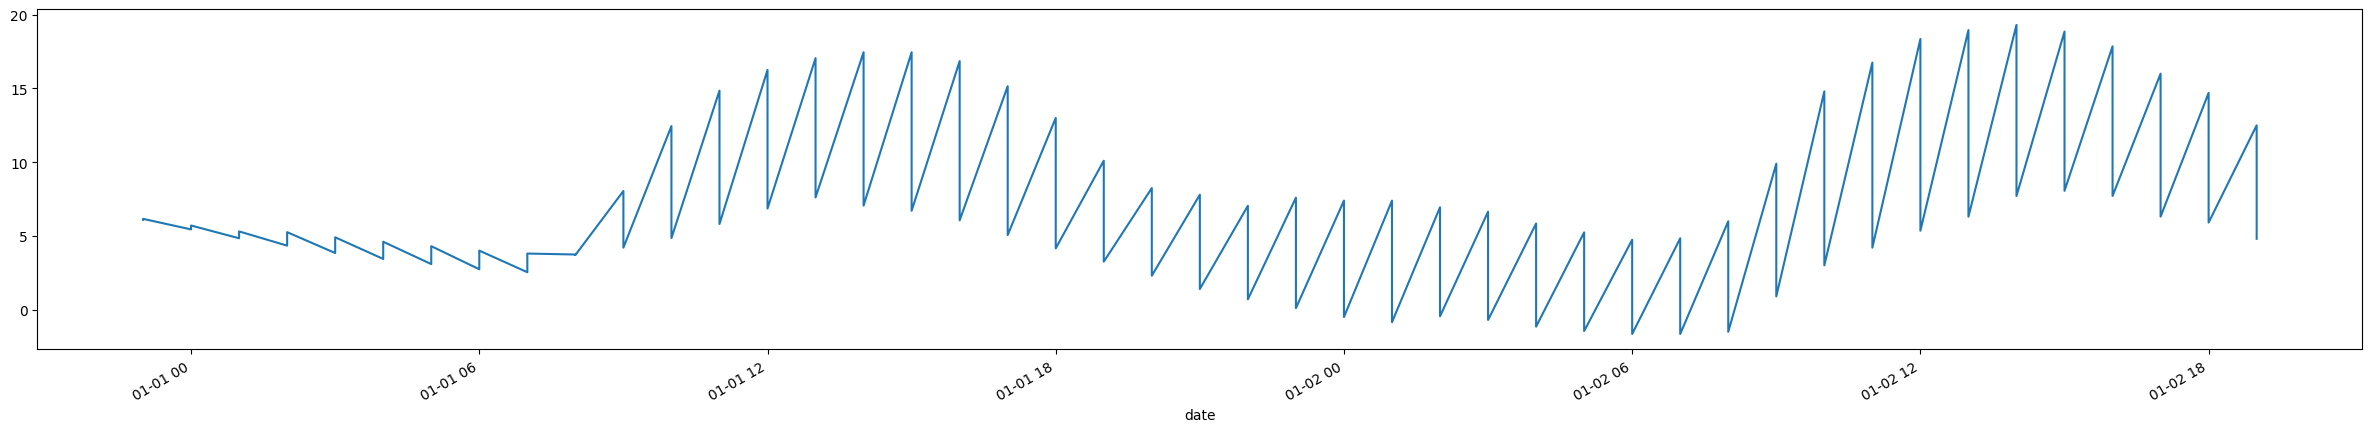

In [138]:
# Check the temperatures match the common sense 
df_weather.set_index("date")["temperature_2m"].iloc[:90].plot(figsize=(30,5))
# spikiness is due to change between Los Angeles and Washington D.C.

In [139]:
df_weather.to_csv("./TempData/weather.csv", index=False)

In [140]:
df_weather = pd.read_csv("./TempData/weather.csv")

### Change to UUID

In [166]:
value_mapping = df_stations[["original_station_id","station_uuid"]].to_dict("records")

value_map = {}

for map_dict in value_mapping:
    value_map[map_dict["original_station_id"]] = map_dict["station_uuid"]
    
df_trips["start_station_uuid"] = df_trips["start_station_id"].replace(value_map)
df_trips["end_station_uuid"] = df_trips["end_station_id"].replace(value_map)

df_trips = df_trips.drop(columns=["start_station_id", "end_station_id"])

In [173]:
df_trips

,trip_uuid,original_trip_id,start_time,end_time,bike_id,member_type,duration,plan_duration,trip_route_category,start_station_uuid,end_station_uuid
0,c7b85897-adbf-42e0-89a7-d7a18103ca60,NaN,2016-01-01 00:06:58,2016-01-01 00:09:44,W01346,member,166.0,NaN,NaN,e7a6fb5b-edbf-4198-b523-698eee94975a,3cece295-6164-48a2-9fac-4d392da359fb
1,38949720-ee02-419f-af83-78a372cc5d89,NaN,2016-01-01 00:10:20,2016-01-01 00:17:48,W22202,member,448.0,NaN,NaN,3e1b60fa-73a2-49e3-8a51-4dafe814f2db,6e18fbc4-ab50-4fae-8241-c99758f84e03
2,11bfdb94-6cb2-457b-9cf3-dbe0ecd868dd,NaN,2016-01-01 00:13:52,2016-01-01 00:25:48,W21427,member,715.0,NaN,NaN,7c58954c-5514-493e-86d7-147ad1dc5933,f6457835-7ade-45f8-b67d-10ca773dd4f6
3,a0366c48-8698-416f-8b81-22c6c916f090,NaN,2016-01-01 00:15:29,2016-01-01 00:19:03,W01294,member,213.0,NaN,NaN,86d52b9c-c6a0-4648-8487-8ffacbb441bd,88e4049c-e658-494e-9582-5b043d04fd2e
4,b7f3deae-d3d5-4ee4-b8b2-9d730788148c,NaN,2016-01-01 00:16:16,2016-01-01 00:30:49,W22058,member,872.0,NaN,NaN,1ff5a2c9-1221-472b-94e0-3331af9caccc,92b032c6-95c6-4413-9863-ff7a15279ee2
...,...,...,...,...,...,...,...,...,...,...,...
35731566,f48c09ee-89c4-4c13-9bde-d905a04023bb,537A4C4D55A133CF,2025-09-30 23:52:22.258,2025-09-30 23:57:17.259,0000_classic,member,NaN,NaN,NaN,5b7aca3d-98df-4669-99e0-e6b6e1f4df71,12bd8baf-4aa4-4f5a-81f9-57dc3c597ced
35731567,ee636ea2-9c2a-4aed-ba5e-0442dc84256e,CEE98DD5ED9E6B63,2025-09-30 23:52:54.178,2025-09-30 23:58:47.132,0000_electric,casual,NaN,NaN,NaN,aae248dd-a351-421e-8639-2614cd2228fd,e3e1e9fe-51a8-437b-8a4b-3821ce30078d
35731568,7a22797d-46fc-432a-94c1-3795f8c32c70,7AA3E55FF072E5D0,2025-09-30 23:53:28.547,2025-09-30 23:58:51.329,0000_electric,casual,NaN,NaN,NaN,25a882d2-4903-4f53-8146-67a6dd6f5e4b,6ee8c9db-b99f-4e7d-a06e-15055005265b
35731569,f42f484e-bd1c-4f4a-a2d6-6bb0a7fa121c,5AE8D1849093DFEB,2025-09-30 23:54:33.014,2025-09-30 23:58:43.502,0000_electric,casual,NaN,NaN,NaN,c262c1c4-3f64-4024-9ead-d9b1563b5289,59f78f27-1c47-4d6d-a262-62e94df791b2


In [169]:
df_trips.to_csv("./CuratedData/trips.csv", index=False)

In [6]:
df_trips = pd.read_csv("./CuratedData/trips.csv")

C:\Users\Vicros2022\AppData\Local\Temp\ipykernel_22436\3842868440.py:1: DtypeWarning: Columns (1,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_trips = pd.read_csv("./CuratedData/trips.csv")


In [8]:
value_mapping = df_bikes[["original_bike_id","bike_uuid"]].to_dict("records")

value_map = {}

for map_dict in value_mapping:
    value_map[map_dict["original_bike_id"]] = map_dict["bike_uuid"]
    
# df_trips["bike_uuid"] = df_trips["bike_id"].replace(value_map)
# df_trips = df_trips.drop(columns=["bike_id"])

In [9]:
value_map

{'04727': '0b0808ea-7902-48e0-a8a8-3aa1d277f32d',
 '04823': 'e9ef6f9d-5d13-42fc-9b91-bc2b83857430',
 '05006': '916354bf-1a29-4a2f-9503-d460ef95d2d3',
 '05016': '02a54712-80e3-4b12-a846-7642adebc579',
 '05027': '658dd281-945a-4d61-a029-d5855c5b2091',
 '05715': 'dc4a1ac9-cc6b-4ca2-a48c-f5aac6aab902',
 '05716': '787d9739-362e-4ae3-a9d8-eb8b2fe420f5',
 '05717': '09e19c91-a445-4749-a17e-b74e6132965c',
 '05718': 'af53d49d-e45e-478c-bfb6-e0a473c55d7d',
 '05719': 'bdbf41ed-dd9a-4c97-850f-18297c3892ef',
 '05720': 'd9e06664-d193-412e-85cb-3d350c4ccf12',
 '05721': 'dcc34cd3-ab35-4d2d-b8f3-a8473fe3c4d4',
 '05723': '404a38e0-577f-46f0-b2c1-252a48a4f3e7',
 '05724': '2bcb373d-4100-4e30-8c6d-6737318c330f',
 '05725': '9d2fddbb-2308-4b57-bc4b-084de67ba7e2',
 '05726': '222d1615-bd31-4f7e-b2b0-a2af116463eb',
 '05727': 'a5c06cdd-07c9-4e01-9d05-c2c8c114665b',
 '05728': 'b77defba-2bce-4c49-85a1-091dd7a56a6c',
 '05729': '22d9f987-f661-451f-a828-1386a71ff551',
 '05730': 'e62510b5-748d-46c1-ae9e-08e20fac05fd',


In [7]:
df_trips

,trip_uuid,original_trip_id,start_time,end_time,bike_id,member_type,duration,plan_duration,trip_route_category,start_station_uuid,end_station_uuid
0,c7b85897-adbf-42e0-89a7-d7a18103ca60,NaN,2016-01-01 00:06:58,2016-01-01 00:09:44,W01346,member,166.0,NaN,NaN,e7a6fb5b-edbf-4198-b523-698eee94975a,3cece295-6164-48a2-9fac-4d392da359fb
1,38949720-ee02-419f-af83-78a372cc5d89,NaN,2016-01-01 00:10:20,2016-01-01 00:17:48,W22202,member,448.0,NaN,NaN,3e1b60fa-73a2-49e3-8a51-4dafe814f2db,6e18fbc4-ab50-4fae-8241-c99758f84e03
2,11bfdb94-6cb2-457b-9cf3-dbe0ecd868dd,NaN,2016-01-01 00:13:52,2016-01-01 00:25:48,W21427,member,715.0,NaN,NaN,7c58954c-5514-493e-86d7-147ad1dc5933,f6457835-7ade-45f8-b67d-10ca773dd4f6
3,a0366c48-8698-416f-8b81-22c6c916f090,NaN,2016-01-01 00:15:29,2016-01-01 00:19:03,W01294,member,213.0,NaN,NaN,86d52b9c-c6a0-4648-8487-8ffacbb441bd,88e4049c-e658-494e-9582-5b043d04fd2e
4,b7f3deae-d3d5-4ee4-b8b2-9d730788148c,NaN,2016-01-01 00:16:16,2016-01-01 00:30:49,W22058,member,872.0,NaN,NaN,1ff5a2c9-1221-472b-94e0-3331af9caccc,92b032c6-95c6-4413-9863-ff7a15279ee2
...,...,...,...,...,...,...,...,...,...,...,...
35731566,f48c09ee-89c4-4c13-9bde-d905a04023bb,537A4C4D55A133CF,2025-09-30 23:52:22.258,2025-09-30 23:57:17.259,0000_classic,member,NaN,NaN,NaN,5b7aca3d-98df-4669-99e0-e6b6e1f4df71,12bd8baf-4aa4-4f5a-81f9-57dc3c597ced
35731567,ee636ea2-9c2a-4aed-ba5e-0442dc84256e,CEE98DD5ED9E6B63,2025-09-30 23:52:54.178,2025-09-30 23:58:47.132,0000_electric,casual,NaN,NaN,NaN,aae248dd-a351-421e-8639-2614cd2228fd,e3e1e9fe-51a8-437b-8a4b-3821ce30078d
35731568,7a22797d-46fc-432a-94c1-3795f8c32c70,7AA3E55FF072E5D0,2025-09-30 23:53:28.547,2025-09-30 23:58:51.329,0000_electric,casual,NaN,NaN,NaN,25a882d2-4903-4f53-8146-67a6dd6f5e4b,6ee8c9db-b99f-4e7d-a06e-15055005265b
35731569,f42f484e-bd1c-4f4a-a2d6-6bb0a7fa121c,5AE8D1849093DFEB,2025-09-30 23:54:33.014,2025-09-30 23:58:43.502,0000_electric,casual,NaN,NaN,NaN,c262c1c4-3f64-4024-9ead-d9b1563b5289,59f78f27-1c47-4d6d-a262-62e94df791b2


In [ ]:
unique_years = df_trips['start_time'].dt.year.unique()

for year in unique_years:
    df_trips_year = df_trips[df_trips['start_time'].dt.year == year]
    file_name = f"./CuratedData/trips_{year}.csv"
    df_trips_year.to_csv(file_name, index=False)
    print(f"Saved {file_name}")

In [381]:
df_trips.to_csv("./CuratedData/trips.csv", index=False)

In [61]:
df_trips = pd.read_csv("./CuratedData/trips.csv")

In [163]:
value_mapping = df_demographics[["zip_code","zip_code_uuid"]].to_dict("records")

value_map = {}

for map_dict in value_mapping:
    value_map[map_dict["zip_code"]] = map_dict["zip_code_uuid"]
    
df_stations["zip_code_uuid"] = df_stations["zip_code"].replace(value_map)
df_stations = df_stations.drop(columns=["zip_code"])

In [164]:
df_stations

,station_uuid,original_station_id,latitude,longitude,station_name,city,zip_code_uuid
0,05083270-d982-4496-9d83-64726bd5629b,3000,34.025841,-118.422859,Virtual Station,Los Angeles,e0c39d16-5761-475b-902c-b3279f4cfd08
1,bfe0d5b5-81a0-4079-8e16-519bad0d654c,3005,34.048500,-118.258537,7th & Flower,Los Angeles,1857faae-3221-4417-842c-eed849d1b9c4
2,3fa6d430-1300-4702-84b6-69825560e5e4,3006,34.045540,-118.256668,Olive & 8th,Los Angeles,1857faae-3221-4417-842c-eed849d1b9c4
3,d312d958-752c-4c51-9401-791babc46113,3007,34.050480,-118.254593,5th & Grand,Los Angeles,077765ea-896e-434f-b854-cc570447fd05
4,6eceb596-66f1-491d-be58-2da8b806d0c9,3008,34.046612,-118.262733,Figueroa & 9th,Los Angeles,1857faae-3221-4417-842c-eed849d1b9c4
...,...,...,...,...,...,...,...
1305,5be63fb5-9232-4f33-8bcd-32a6df1494eb,33000,38.904912,-77.058096,29th & M St NW,Washington D.C.,f11d0a0e-a191-4c59-a640-fb6bfb4cfc05
1306,aaa467ef-8f78-4b09-a270-9ecae035a42e,33001,38.866105,-77.013645,2nd & U St SW,Washington D.C.,00ae5e46-bb9c-45e8-8e6c-3dce28166fb1
1307,bee9bc47-542d-4e80-8d7c-989932b0d963,33101,38.921583,-77.038564,17th St & Kalorama Rd NW,Washington D.C.,5492cd9e-e574-441a-8e6d-56d95e8127c6
1308,a954d324-4a0b-46b1-8eb9-2764718b34a7,33200,38.896604,-77.039778,17th St & New York Ave NW,Washington D.C.,64620609-6aff-4875-b592-8c22c8251530


In [165]:
df_stations.to_csv("./CuratedData/stations.csv", index=False)

In [61]:
df_stations = pd.read_csv("./CuratedData/stations.csv")

In [141]:
pd.merge([df_trips, df_stations[["original"]]]

,trip_uuid,original_trip_id,start_time,end_time,start_station_id,end_station_id,bike_id,member_type,duration,plan_duration,trip_route_category
0,c7b85897-adbf-42e0-89a7-d7a18103ca60,NaN,2016-01-01 00:06:58.000,2016-01-01 00:09:44.000,31102,31105,W01346,member,166.0,NaN,NaN
1,38949720-ee02-419f-af83-78a372cc5d89,NaN,2016-01-01 00:10:20.000,2016-01-01 00:17:48.000,32039,32002,W22202,member,448.0,NaN,NaN
2,11bfdb94-6cb2-457b-9cf3-dbe0ecd868dd,NaN,2016-01-01 00:13:52.000,2016-01-01 00:25:48.000,31222,31214,W21427,member,715.0,NaN,NaN
3,a0366c48-8698-416f-8b81-22c6c916f090,NaN,2016-01-01 00:15:29.000,2016-01-01 00:19:03.000,31506,31509,W01294,member,213.0,NaN,NaN
4,b7f3deae-d3d5-4ee4-b8b2-9d730788148c,NaN,2016-01-01 00:16:16.000,2016-01-01 00:30:49.000,31041,31048,W22058,member,872.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
35731566,f48c09ee-89c4-4c13-9bde-d905a04023bb,537A4C4D55A133CF,2025-09-30 23:52:22.258,2025-09-30 23:57:17.259,31232,31251,0000_classic,member,NaN,NaN,NaN
35731567,ee636ea2-9c2a-4aed-ba5e-0442dc84256e,CEE98DD5ED9E6B63,2025-09-30 23:52:54.178,2025-09-30 23:58:47.132,31137,31120,0000_electric,casual,NaN,NaN,NaN
35731568,7a22797d-46fc-432a-94c1-3795f8c32c70,7AA3E55FF072E5D0,2025-09-30 23:53:28.547,2025-09-30 23:58:51.329,31311,31223,0000_electric,casual,NaN,NaN,NaN
35731569,f42f484e-bd1c-4f4a-a2d6-6bb0a7fa121c,5AE8D1849093DFEB,2025-09-30 23:54:33.014,2025-09-30 23:58:43.502,31674,31680,0000_electric,casual,NaN,NaN,NaN


In [130]:
# verify everything can be link together
start = pd.to_datetime("2016-01-01 00:00:00")
end = pd.to_datetime("2016-02-01 00:00:00")

df_query = df_trips.loc[(df_trips["start_time"] >= start) & (df_trips["start_time"] <= end)]
df_query = pd.merge(df_query, df_stations, left_on="start_station_id", right_on="original_station_id")
df_query = pd.merge(df_query, df_demographics, on="zip_code")

df_query_weather = df_weather.loc[(df_weather["date"] >= start) & (df_weather["date"] <= end)]

df_query = pd.merge_asof(
    df_query, 
    df_query_weather,
    left_on = "start_time",
    right_on = "date",
    by='city',
    direction='nearest',
    # tolerance=pd.Timedelta('60 minutes') # Optional: set a maximum tolerance
)


df_query

,trip_uuid_x,original_trip_id,start_time,end_time,start_station_id,end_station_id,bike_id,member_type,duration,plan_duration,...,cloud_cover_mid,cloud_cover_high,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,soil_temperature_0_to_7cm,soil_moisture_0_to_7cm,soil_temperature_7_to_28cm,soil_moisture_7_to_28cm,wind_speed_100m
0,c7b85897-adbf-42e0-89a7-d7a18103ca60,NaN,2016-01-01 00:06:58,2016-01-01 00:09:44,31102,31105,W01346,member,166.0,NaN,...,8.0,97.0,0.032821,0.374834,11.592894,8.158501,0.477,10.658501,0.484,19.083395
1,38949720-ee02-419f-af83-78a372cc5d89,NaN,2016-01-01 00:10:20,2016-01-01 00:17:48,32039,32002,W22202,member,448.0,NaN,...,8.0,97.0,0.032821,0.374834,11.592894,8.158501,0.477,10.658501,0.484,19.083395
2,11bfdb94-6cb2-457b-9cf3-dbe0ecd868dd,NaN,2016-01-01 00:13:52,2016-01-01 00:25:48,31222,31214,W21427,member,715.0,NaN,...,8.0,97.0,0.032821,0.374834,11.592894,8.158501,0.477,10.658501,0.484,19.083395
3,a0366c48-8698-416f-8b81-22c6c916f090,NaN,2016-01-01 00:15:29,2016-01-01 00:19:03,31506,31509,W01294,member,213.0,NaN,...,8.0,97.0,0.032821,0.374834,11.592894,8.158501,0.477,10.658501,0.484,19.083395
4,b7f3deae-d3d5-4ee4-b8b2-9d730788148c,NaN,2016-01-01 00:16:16,2016-01-01 00:30:49,31041,31048,W22058,member,872.0,NaN,...,8.0,97.0,0.032821,0.374834,11.592894,8.158501,0.477,10.658501,0.484,19.083395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122919,c0e4d389-306f-405a-95de-e82d9aadc706,NaN,2016-01-31 23:44:51,2016-02-01 00:13:36,31204,31235,W20114,casual,1725.0,NaN,...,0.0,78.0,0.011653,0.159409,17.317460,0.708500,0.463,1.308500,0.490,35.900860
122920,653f06d9-020a-4755-a58a-2e1aa3086bfb,NaN,2016-01-31 23:47:38,2016-01-31 23:49:59,31281,31245,W21141,member,140.0,NaN,...,0.0,78.0,0.011653,0.159409,17.317460,0.708500,0.463,1.308500,0.490,35.900860
122921,7b56b044-03b9-49fa-886e-b75f354bdb1c,NaN,2016-01-31 23:48:25,2016-01-31 23:58:35,31109,31105,W01274,member,610.0,NaN,...,0.0,78.0,0.011653,0.159409,17.317460,0.708500,0.463,1.308500,0.490,35.900860
122922,acdd4b7e-4b3f-4713-89a0-0025723b5b7d,NaN,2016-01-31 23:49:19,2016-01-31 23:55:00,31600,31251,W21583,member,340.0,NaN,...,0.0,78.0,0.011653,0.159409,17.317460,0.708500,0.463,1.308500,0.490,35.900860


In [110]:
df_query.columns

Index(['trip_uuid_x', 'original_trip_id', 'start_time', 'end_time',
       'start_station_id', 'end_station_id', 'bike_id', 'member_type',
       'duration', 'plan_duration', 'trip_route_category', 'station_uuid',
       'original_station_id', 'latitude', 'longitude', 'station_name',
       'zip_code', 'city', 'zip_code_uuid', 'median_household_income',
       'household_income_200000_to_more', 'household_income_150000_to_199999',
       'household_income_125000_to_149999',
       'household_income_100000_to_124999', 'household_income_75000_to_99999',
       'household_income_60000_to_74999', 'household_income_50000_to_59999',
       'household_income_45000_to_49999', 'household_income_40000_to_44999',
       'household_income_35000_to_39999', 'household_income_30000_to_34999',
       'household_income_25000_to_29999', 'household_income_20000_to_24999',
       'household_income_15000_to_19999', 'household_income_10000_to_14999',
       'household_income_1_to_9999', 'transportation_work

## Feature Engineering 

## Workflow Automation

## Predictive Analysis